This notebook aims to be a beginner-friendly introduction to training-free Sparse Attention mechanisms.
- **We prioritise clarity over performance.** We use pure PyTorch to implement recent Sparse Attention mechanisms for both prefilling and generation stages. This allows us to focus on the core ideas. However, this also makes our implementations less efficient and one should not expect them to be competitive with optimised implementations.
- **We use SOTA model and real-world summarization dataset.** We use state-of-the-art model [Llama-3.2-1B-Instruct](https://huggingface.co/unsloth/Llama-3.2-1B-Instruct) and [FiscalNote/billsum](https://huggingface.co/datasets/FiscalNote/billsum) summarization dataset for the experiments.
- **We focus on the core and import everything else.** We focus on providing clean implementations of Sparse Attention mechanisms. Setting up the environment, loading the dataset, loading the model, plotting the results is a lot of code which is not relevant to the core ideas and can be overwhelming. Everything that does not relate to the core is imported from the [main repository](https://github.com/PiotrNawrot/nano-sparse-attention) - in case of any questions or issues please raise an issue there.

# Background

Self-Attention in Transformers is a mechanism that allows the Transformer model to focus on relevant parts of the input sequence when making predictions. Unfortunatelly, especially for longer sequences, it is also the main source of computational inefficiency. Hence, many Sparse Attention mechanisms have been proposed which aims to reduce the complexity of the attention computation.

LLMs inference operates in two stages:
1. **Prefilling**: The model computes the hidden representations for the input, i.e., Model Template, User Prompt, User Question.
2. **Generation**: The model generates the answer to the question in the prompt, token by token.

These two stages, although they utilise the same mechanism under the hood, have different challenges:
- **Prefilling** is a computationally heavy operation, dominated by the quadratic complexity w.r.t. the sequence length. In this stage, Sparse Attention methods aims to identify a subset of important token interactions and approximate the attention output with this subset.
- **Generation** is computationally linear in the sequence length for each generation step, so it is computationally cheaper than prefilling. However, fast growing memory footprint, caused by token representations from all previous steps, causes many problems which all eventually lead to heavy underutilisation of GPU hardware. As a remedy, Sparse Attention aims to reduce the memory footprint by identifying a crucial subset of tokens for the upcoming generations, and discarding the rest. 


# Prefilling Stage

## Setup

In [ ]:
# Install the library from github to have access to helper functions such as loading the model, loading the dataset, etc.
# In Google Colab, ETA for running the entire notebook with T4 GPU is ~20 minutes - with CPU it will be much longer.

!pip install git+https://github.com/PiotrNawrot/nano-sparse-attention.git

In [1]:
# Use only one GPU in case running on a machine with multiple GPUs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Increase dpi for better plot quality
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 600

In [2]:
import math
import torch
import torch.nn.functional as F

from nano_sparse_attn.utils import (
    load_model_and_tokenizer,
    load_examples,
    model_forward,
    update_attention,
    plot_prefill_masks,
    plot_generation_masks,
    plot_sparse_attention_results,
    CONSTANTS,
)

from nano_sparse_attn.attention import Attention, InferenceHandler

model, tokenizer = load_model_and_tokenizer()
model_inputs = load_examples(
    tokenizer,
    target_length_min=CONSTANTS['runtime_args']['target_length_min'],
    target_length_max=CONSTANTS['runtime_args']['target_length_max'],
    num_examples=CONSTANTS['runtime_args']['num_examples'],
)

# Accumulator for storing the results of different attention patterns with different parameters.
# We'll use it later to plot the results and compare different patterns.
global_results = []

def execute_print_save(model, inference_handler, model_inputs):
    """Execute model forward pass with given attention pattern, print results, and save metrics.
    
    Args:
        model: The transformer model to run inference with
        inference_handler: Handler containing prefill and generation attention patterns
        model_inputs: Tokenized input sequences
        
    Returns:
        execution_info: Dictionary containing sparsity metrics for given patterns.
    """
    update_attention(model, inference_handler)
    loss = model_forward(model, model_inputs, inference_handler)
    execution_info = inference_handler.info()

    processed_info = {
        'name': execution_info['prefill']['name'],
        'sparsity': execution_info['prefill']['sparsity'],
        'loss': loss
    }

    print(processed_info)
    global_results.append(processed_info)
    return execution_info


/home/ubuntu/pnawrot/nano-sparse-attention/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we'll go through a few example attention patterns for prefilling:
- Dense Attention
- Local Window + Attention Sinks
    - [(Xiao et al, 2023)](https://arxiv.org/abs/2309.17453)
    - [(Han et al, 2024)](https://arxiv.org/abs/2308.16137)
- Vertical and Slash Attention
    - [(Jiang et al, 2024)](https://arxiv.org/abs/2407.02490)
- Block Sparse Attention
    - [(Jiang et al, 2024)](https://arxiv.org/abs/2407.02490)

For each pattern, we will now
- Evaluate it for different parameter settings and print the language modelling loss over the output tokens, as well as the resulting sparsity;
- Visualise example attention masks;
- Save the results for later use.


## Dense Attention

{'name': 'DenseAttention', 'sparsity': 0, 'loss': 1.4140625}


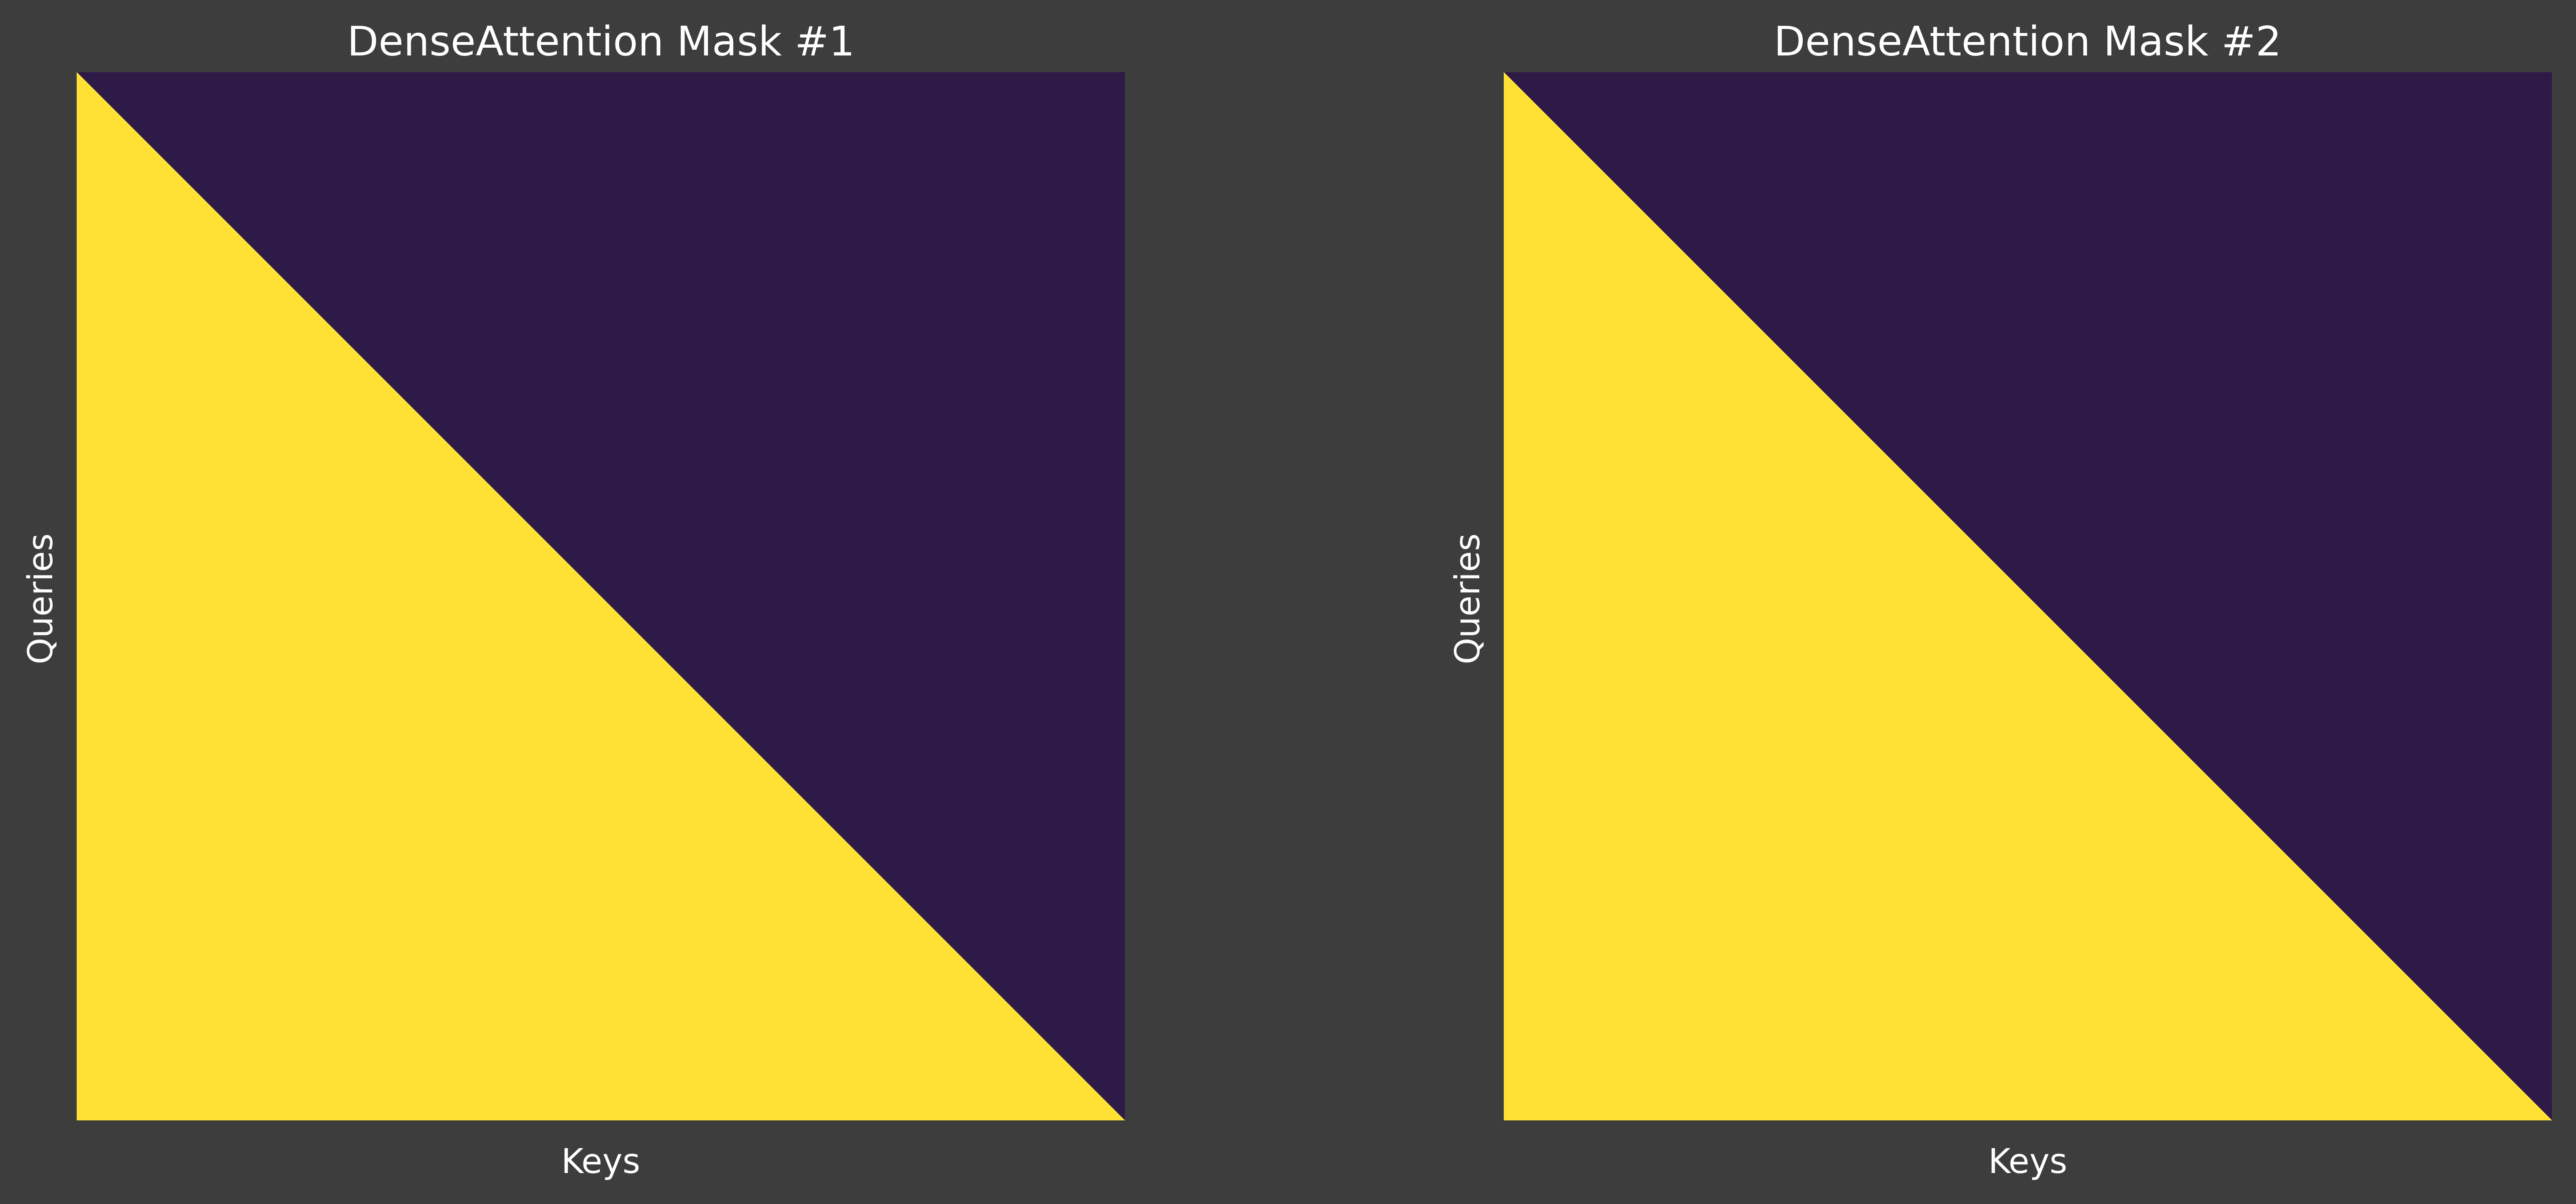

In [3]:
class DenseAttention(Attention):
    def __init__(self):
        super().__init__()
        self.name = 'DenseAttention'

    def forward(self, queries, keys, values, *args, **kwargs):
        attention_mask = self.get_causal_mask(queries.size(-2), queries.device)
        self.maybe_save_mask(attention_mask)
        return self.attention(queries, keys, values, attention_mask)

    def generation_forward(self, prefilling_queries, prefilling_keys, prefilling_values,
                         generation_queries, generation_keys, generation_values, *args, **kwargs):
        keys = torch.cat([prefilling_keys, generation_keys], dim=-2)
        values = torch.cat([prefilling_values, generation_values], dim=-2)
        
        generation_mask = self.get_generation_mask(
            gen_len=generation_queries.size(-2),
            prefill_len=prefilling_keys.size(-2),
            device=generation_queries.device
        )
        
        return self.attention(generation_queries, keys, values, generation_mask)


inference_handler = InferenceHandler(
    prefill_attention=DenseAttention(),
    generation_attention=DenseAttention(),
)

execution_info = execute_print_save(model, inference_handler, model_inputs)

plot_prefill_masks(
    mask1=execution_info['prefill']['masks'][0],
    mask2=execution_info['prefill']['masks'][1],
    title=execution_info['prefill']['name']
)

For attention masks visualisation, we use the following convention:
- **Yellow** - a given interaction between Query and Key is allowed
- **Blue** - a given interaction between Query and Key is filtered out

## Local Window + Attention Sinks

{'name': 'LocalAndSinksAttention', 'sparsity': 0.9304029072324435, 'loss': 1.5963541666666667}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.9002766907215118, 'loss': 1.5520833333333333}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.8706463674704233, 'loss': 1.5260416666666667}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.841511939962705, 'loss': 1.5130208333333333}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.8128734032313029, 'loss': 1.5052083333333333}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.7847307672103246, 'loss': 1.4947916666666667}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.7570840169986089, 'loss': 1.4765625}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.7299331625302633, 'loss': 1.4739583333333333}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.7032782038052877, 'loss': 1.4895833333333333}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.6771191358566284, 'loss': 1.4817708333333333}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.65145595868

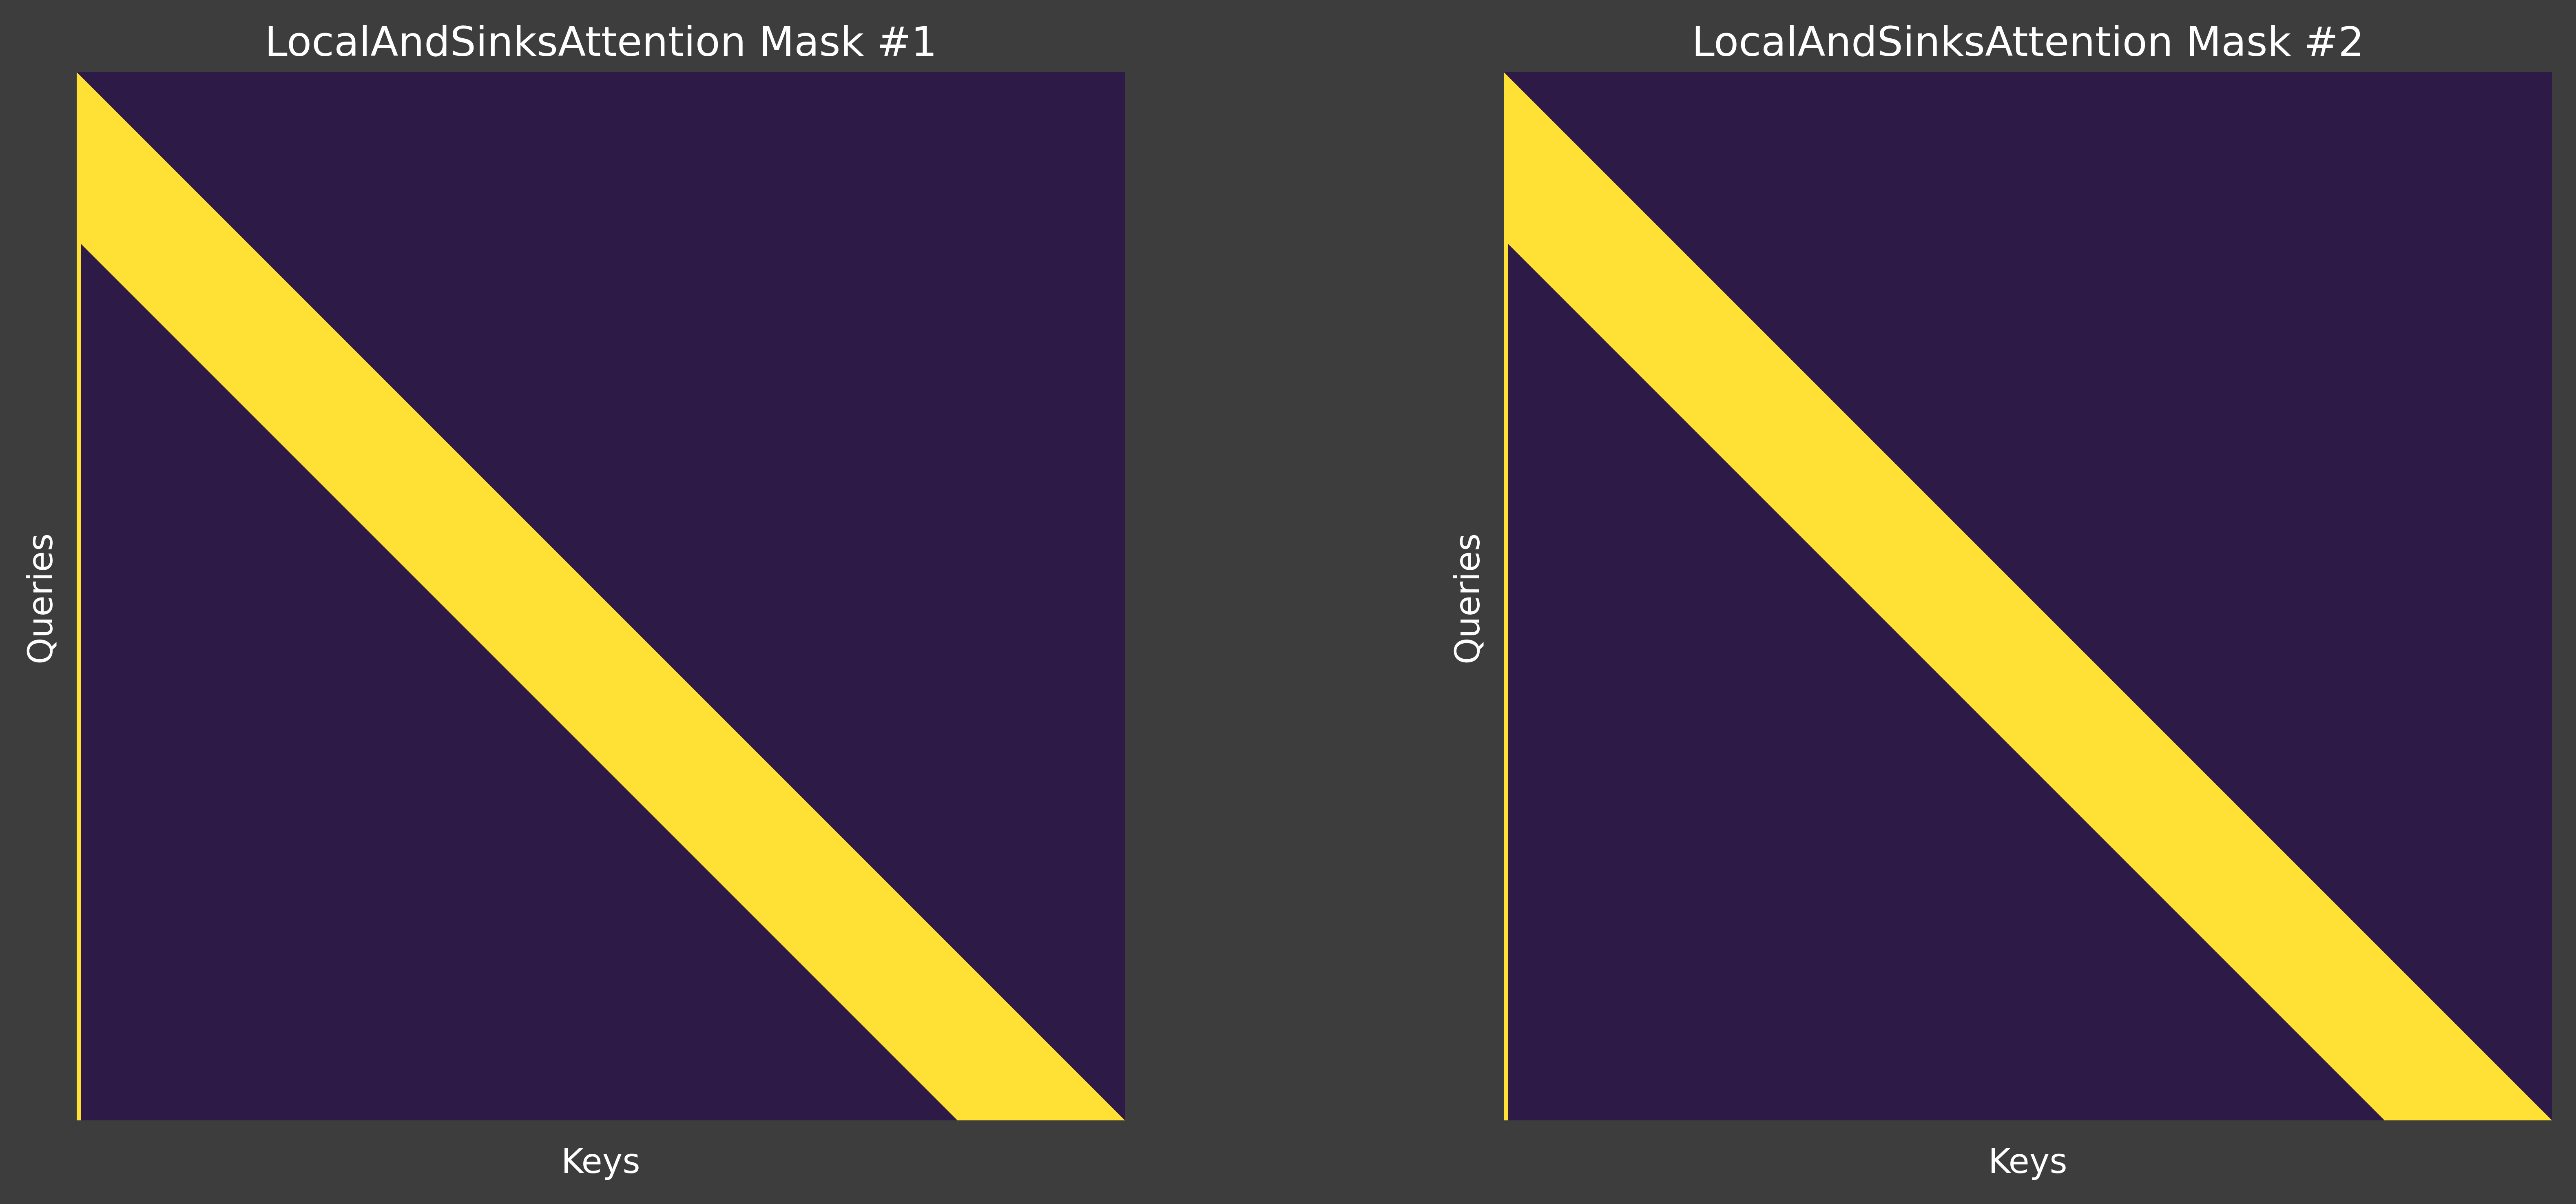

In [4]:
class LocalAndSinksAttention(Attention):
    """Implements a sparse attention pattern combining local windows with global attention sinks.
    
    This attention mechanism reduces computational complexity by:
    1. Allowing each token to attend only to nearby tokens within a fixed window
    2. Designating the first K tokens as "attention sinks" that can be attended to by all tokens
    
    This patterns makes a Markov assumption that each token's dependencies are primarily 
    contained within its local neighborhood, limiting long-range interactions to reduce complexity.
    
    Attention sinks are special tokens (typically at the start of the sequence) that maintain
    global connectivity - every token can attend to them, allowing them to serve as aggregators
    and distributors of global context information throughout the sequence.
    
    This creates a sparse pattern where most tokens have local connectivity, but important
    context tokens (sinks) maintain global connectivity.

    Args:
        window_size (int): Size of the local attention window around each token
        attention_sinks (int): Number of initial tokens that serve as global attention sinks
    
    Reference Papers:
        - (Xiao et al, 2023) https://arxiv.org/abs/2309.17453
        - (Han et al, 2024) https://arxiv.org/abs/2308.16137
    """
    def __init__(self, window_size, attention_sinks):
        super().__init__()
        self.name = 'LocalAndSinksAttention'
        self.params = {
            "window_size": window_size,
            "attention_sinks": attention_sinks
        }
    
    def create_mask(self, seq_len, device):
        """Creates sparse attention mask with local windows and global sinks."""
        assert self.window_size <= seq_len, "Window size must be less or equal to sequence length"
        assert self.attention_sinks <= seq_len, "Number of attention sinks must be less or equal to sequence length"
        
        # Create base local attention window
        mask = self.get_local_mask(seq_len, self.window_size, device)

        # Allow attention to sink tokens
        mask[..., :, :self.attention_sinks] = 0
        mask = mask | self.get_causal_mask(seq_len, device)

        return mask
    
    def forward(self, queries, keys, values, *args, **kwargs):
        """Sparse attention for prefilling."""
        attention_mask = self.create_mask(queries.size(-2), queries.device)

        self.sparsity_ratios.append(self.calculate_sparsity_ratio(attention_mask))
        self.maybe_save_mask(attention_mask)

        return self.attention(queries, keys, values, attention_mask)


for window_size in range(128, 1024, 64):
    inference_handler = InferenceHandler(
        prefill_attention=LocalAndSinksAttention(
            window_size=window_size,
            attention_sinks=16,
        ),
        generation_attention=DenseAttention(),
    )

    execution_info = execute_print_save(model, inference_handler, model_inputs)

    if window_size == 640:
        plot_prefill_masks(
            mask1=execution_info['prefill']['masks'][0],
            mask2=execution_info['prefill']['masks'][1],
            title=execution_info['prefill']['name']
        )

## VerticalAndSlashAttention

{'name': 'VerticalAndSlashAttention', 'sparsity': 0.9479895687351624, 'loss': 1.5963541666666667}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.9169511757791042, 'loss': 1.5130208333333333}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.8869383574152986, 'loss': 1.5}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.8576286553094784, 'loss': 1.4765625}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.8286323258653283, 'loss': 1.46875}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.7999901849155625, 'loss': 1.4609375}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.7716701903070012, 'loss': 1.4609375}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.743815909139812, 'loss': 1.4557291666666667}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.7163919496039549, 'loss': 1.453125}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.6896088241289059, 'loss': 1.4505208333333333}
{'name': 'VerticalAndSlashAttention', 'sparsity': 0.663249051819245, 'loss': 1.44531

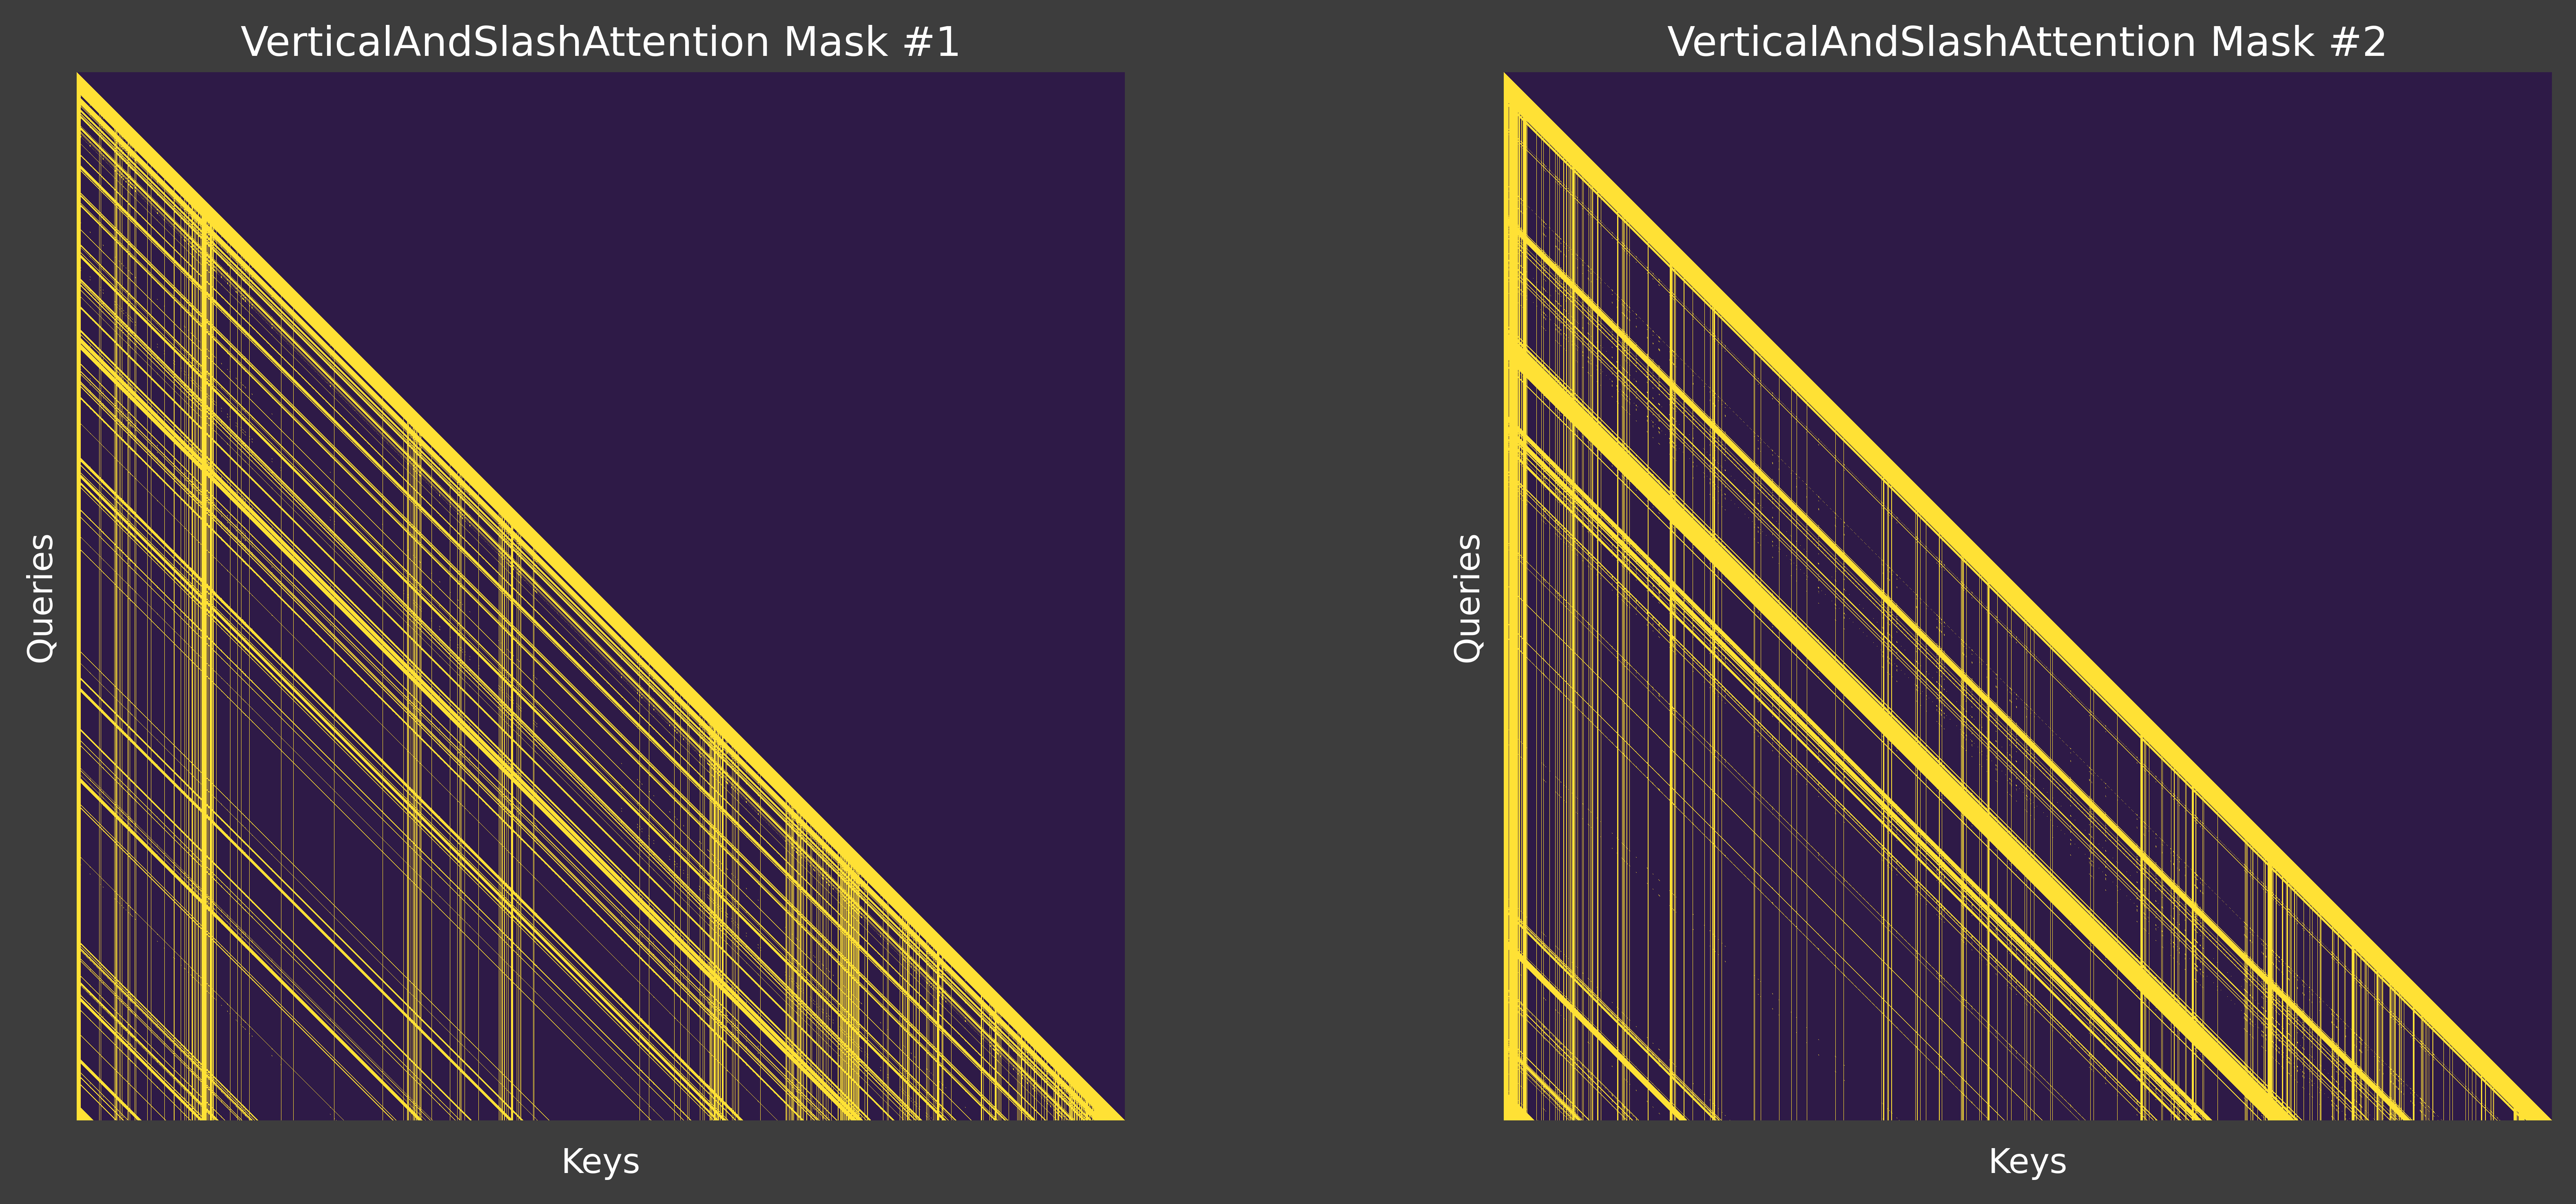

In [5]:
class VerticalAndSlashAttention(Attention):
    """Implements a content-dependent sparse attention combining top tokens and diagonal patterns,
    known as Vertical-Slash, introduced by (Jiang et al, 2024) in the MInference 1.0 paper.
    
    This attention mechanism creates a sparse pattern by combining two types of connectivity:
    1. Dynamic attention to top-K most relevant tokens (content-based)
    2. Dynamic attention along top-K diagonal stripes (structure-based)
    
    The diagonal stripes (slashes) capture recurring patterns at fixed offsets, while
    top tokens capture semantic relevance. This combines structural and semantic sparsity.
    Contrary to the Local Window + Attention Sinks, this pattern does not make any
    assumptions about the local context of each token, and instead identifies the most
    important interactions based on the content and structure of the input.

    Args:
        attention_sinks (int): Number of initial tokens that serve as global attention sinks
        window_size (int): Size of the local attention window around each token
        top_tokens (int): Number of highest-scoring tokens to attend to globally
        top_slashes (int): Number of diagonal stripes to include in the pattern
        approximation_window (int): Size of the window used to approximate attention scores

    Reference Papers:
        - (Jiang et al, 2024) https://arxiv.org/abs/2407.02490
    """
    def __init__(self, attention_sinks, window_size, top_tokens, top_slashes, approximation_window):
        super().__init__()
        self.name = 'VerticalAndSlashAttention'
        self.params = {
            "attention_sinks": attention_sinks,
            "window_size": window_size,
            "top_tokens": top_tokens,
            "top_slashes": top_slashes,
            "approximation_window": approximation_window,
        }
    
    def fill_diagonals(self, L: int, indexes: torch.Tensor, device='cuda', chunk_size=1024):
        """
        Memory-efficient implementation to create a mask LxL with diagonals filled with False.
        Processes diagonals in chunks to reduce peak memory usage.
        
        Parameters:
        - L (int): The size of the square matrix.
        - indexes (torch.Tensor): Tensor of shape (B, H, M) with integer values which determine 
          the diagonals to be filled in the output matrix for each batch and head.
        - device: The device to perform computations on ('cuda' or 'cpu').
        - chunk_size: Size of chunks to process at once to manage memory usage.
        
        Returns:
        - mask (torch.Tensor): A boolean matrix of size (B, H, L, L) with specified diagonals filled with True.
        """
        assert (indexes <= 0).all().item(), "Indexes must be on or below diagonal."
        
        batch_size, num_heads, num_diagonals = indexes.shape
        
        # Create output tensor
        mask_dense = torch.ones((batch_size, num_heads, L, L), dtype=torch.bool, device=device)
        
        # Process the sequence length in chunks
        for chunk_start in range(0, L, chunk_size):
            chunk_end = min(chunk_start + chunk_size, L)
            chunk_len = chunk_end - chunk_start
            
            # Create row indices for this chunk
            row_indices = torch.arange(chunk_start, chunk_end, device=device, dtype=torch.int32)
            row_indices = row_indices.view(1, 1, 1, chunk_len)
            row_indices = row_indices.expand(batch_size, num_heads, num_diagonals, chunk_len)
            
            # Add the diagonal offsets to get column indices
            col_indices = row_indices + indexes.unsqueeze(-1).to(torch.int32)
            
            # Mask out indices that are out of bounds
            valid_mask = (col_indices >= 0) & (col_indices < L)
            
            if not valid_mask.any():
                continue
                
            # Create batch and head indices for valid positions only
            batch_idx = torch.arange(batch_size, device=device).view(-1, 1, 1, 1)
            batch_idx = batch_idx.expand(-1, num_heads, num_diagonals, chunk_len)
            head_idx = torch.arange(num_heads, device=device).view(1, -1, 1, 1)
            head_idx = head_idx.expand(batch_size, -1, num_diagonals, chunk_len)
            
            # Select only valid indices
            valid_batch_idx = batch_idx[valid_mask]
            valid_head_idx = head_idx[valid_mask]
            valid_row_idx = row_indices[valid_mask]
            valid_col_idx = col_indices[valid_mask]
            
            # Set the valid diagonal elements to False
            mask_dense[valid_batch_idx, valid_head_idx, valid_row_idx, valid_col_idx] = False
            
            # Free memory explicitly
            del row_indices, col_indices, valid_mask, batch_idx, head_idx
            
        return mask_dense

    def sum_over_diagonals(self, matrix):
        """Efficiently sum values along diagonals of the attention matrix.
        
        This method uses stride tricks to efficiently extract and sum diagonals:
        1. Pad the matrix with zeros on both sides to handle all possible diagonals
        2. Create a strided view that groups elements along diagonals
        3. Sum along each diagonal to get their total attention scores
        
        The strided operation creates a view where each row contains elements from
        one diagonal, allowing for efficient parallel summation.
        
        Args:
            matrix: Attention scores tensor of shape (batch_size, num_heads, queries, keys)
            
        Returns:
            Tensor of shape (batch_size, num_heads, queries + keys - 1) containing
            summed attention scores for each diagonal

        This function is based on the implementation from: 
            https://github.com/microsoft/MInference/blob/main/minference/modules/minference_forward.py#L101
        """
        batch_size, num_heads, queries, keys = matrix.shape
        zero_matrix = torch.zeros((batch_size, num_heads, queries, queries)).to(matrix.device)
        matrix_padded = torch.cat((zero_matrix, matrix, zero_matrix), -1)
        matrix_strided = matrix_padded.as_strided(
            (
                batch_size,
                num_heads,
                queries,
                queries + keys
            ),
            (
                num_heads * queries * (2 * queries + keys),
                queries * (2 * queries + keys),
                2 * queries + keys + 1,
                1
            )
        )
        sum_diagonals = torch.sum(matrix_strided, 2)
        return sum_diagonals[:, :, 1:]

    def create_mask(self, queries, keys, seq_len, device):
        assert self.top_slashes <= seq_len
        assert self.top_tokens <= seq_len
        assert self.top_slashes >= self.window_size
        assert self.attention_sinks <= self.top_tokens

        # Approximate attention scores
        approx_queries = queries[..., -self.approximation_window:, :]
        attention_scores = torch.matmul(approx_queries, keys.transpose(-2, -1)) / math.sqrt(queries.size(-1))
        attention_scores[..., -self.approximation_window:] += self.get_causal_mask(self.approximation_window, device) * torch.finfo(queries.dtype).min
        attention_scores = torch.nn.functional.softmax(attention_scores, dim=-1, dtype=torch.float32).to(queries.dtype)
        
        # Get top tokens
        summed_scores = attention_scores.sum(dim=-2)
        summed_scores[..., :self.attention_sinks] = torch.inf
        top_k_indices = torch.topk(summed_scores, self.top_tokens, dim=-1, sorted=False).indices

        # Get top_k slashes
        top_k_slash = self.sum_over_diagonals(attention_scores)[..., :-self.approximation_window + 1]
        top_k_slash[..., -self.window_size:] = torch.inf
        top_k_slash = torch.topk(top_k_slash, self.top_slashes, -1).indices - (seq_len - 1)

        # Get final mask
        mask = self.fill_diagonals(seq_len, top_k_slash, device)
        mask.scatter_(-1, top_k_indices.unsqueeze(-2).expand(-1, -1, seq_len, -1), 0)
        mask = mask | self.get_causal_mask(seq_len, device)

        return mask

    def forward(self, queries, keys, values, *args, **kwargs):
        """Sparse attention for prefilling using top tokens and slashes."""
        attention_mask = self.create_mask(queries, keys, queries.size(-2), queries.device)
        
        self.sparsity_ratios.append(self.calculate_sparsity_ratio(attention_mask))
        self.maybe_save_mask(attention_mask)

        return self.attention(queries, keys, values, attention_mask)


for top_k in range(128, 1024, 64):
    inference_handler = InferenceHandler(
        prefill_attention=VerticalAndSlashAttention(
            top_tokens=top_k,
            top_slashes=top_k,
            attention_sinks=16,
            window_size=64,
            approximation_window=64,
        ),
        generation_attention=DenseAttention(),
    )

    execution_info = execute_print_save(model, inference_handler, model_inputs)

    if top_k == 640:
        plot_prefill_masks(
            mask1=execution_info['prefill']['masks'][0],
            mask2=execution_info['prefill']['masks'][1],
            title=execution_info['prefill']['name']
        )

## BlockSparseAttention

{'name': 'BlockSparseAttention', 'sparsity': 0.9349179111110667, 'loss': 1.6197916666666667}
{'name': 'BlockSparseAttention', 'sparsity': 0.8889408465474844, 'loss': 1.5416666666666667}
{'name': 'BlockSparseAttention', 'sparsity': 0.8320369233066837, 'loss': 1.4921875}
{'name': 'BlockSparseAttention', 'sparsity': 0.7762345274289449, 'loss': 1.4739583333333333}
{'name': 'BlockSparseAttention', 'sparsity': 0.7221314137180647, 'loss': 1.4427083333333333}
{'name': 'BlockSparseAttention', 'sparsity': 0.6698483570168415, 'loss': 1.4348958333333333}
{'name': 'BlockSparseAttention', 'sparsity': 0.6194480583071709, 'loss': 1.4348958333333333}
{'name': 'BlockSparseAttention', 'sparsity': 0.57096225147446, 'loss': 1.4348958333333333}


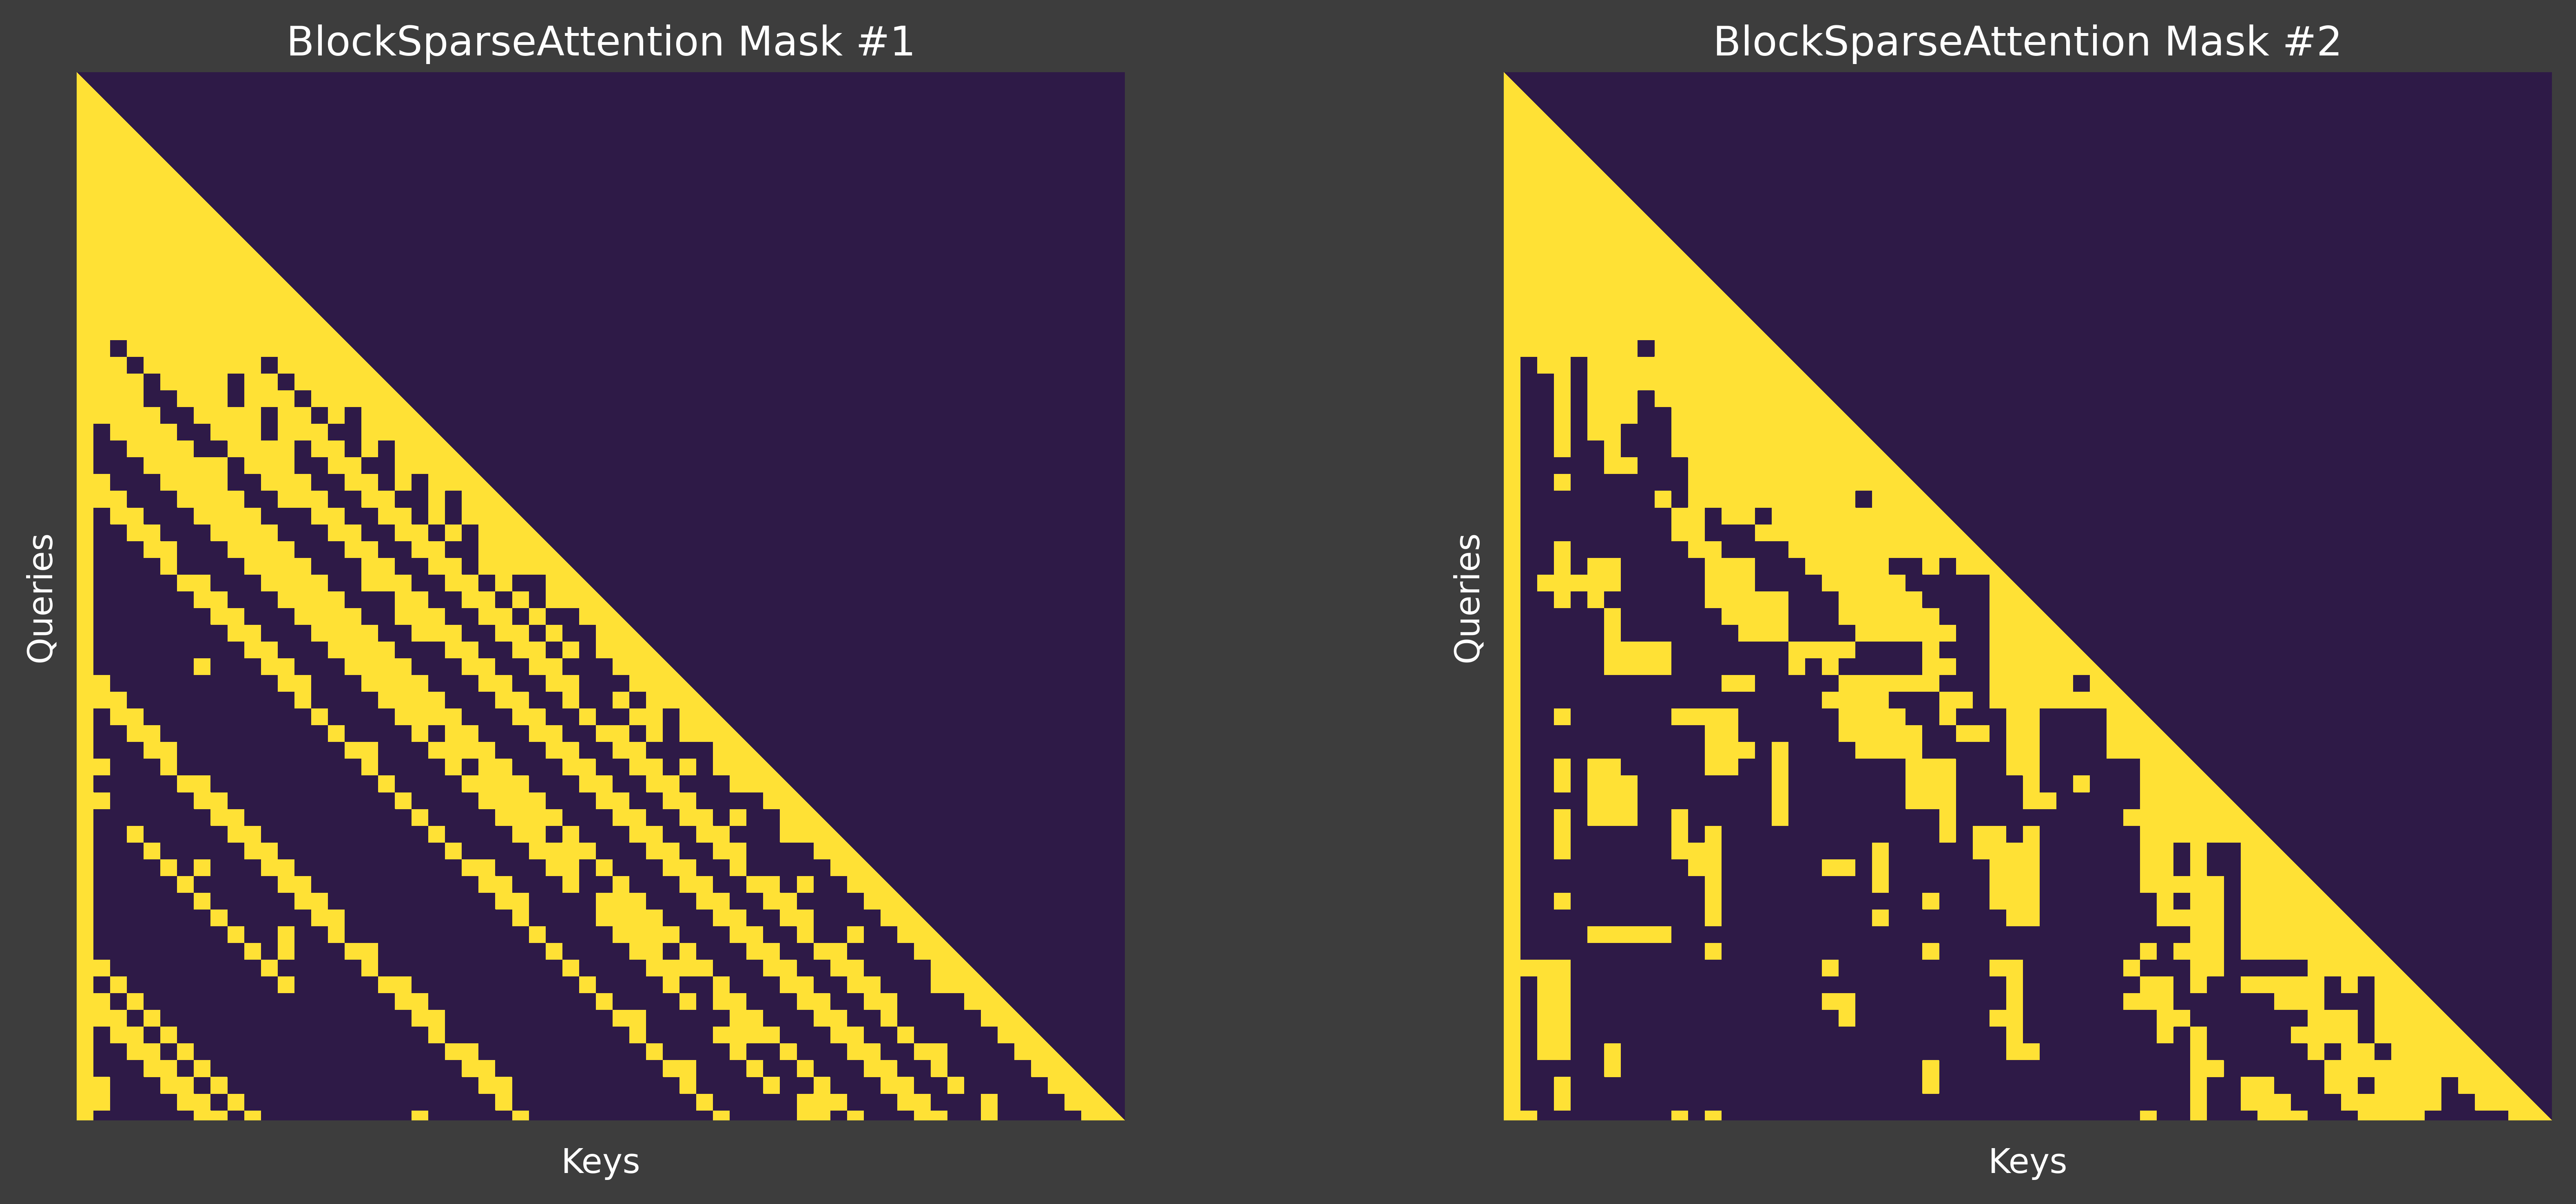

In [6]:
class BlockSparseAttention(Attention):
    """Implements a Block-Sparse Attention pattern based on chunk-level relevance,
    introduced by (Jiang et al, 2024) in the MInference 1.0 paper.
    
    This attention mechanism reduces complexity by operating on chunks of tokens:
    1. Divides the sequence into fixed-size chunks.
    2. Computes chunk-level attention scores with averaged token representations.
    3. Allows each chunk to attend to the top-K most relevant chunks.
    
    This creates a coarse-grained sparse pattern where entire blocks of tokens attend
    to each other, making it efficient for long sequences while preserving approximate
    attention patterns.
    
    Contrary to the original paper, in this implementation we additionally:
    1. Include the local window of size chunk_size around each token because we found
       it crucial for performance and it is non trivial to be executed by this pattern
       for high sparsity ratios.
    2. Always pick the prefix chunk because we also found it crucial for performance but
       it is not always picked as top-1 chunk.

    For this reason, top_chunks = 1 BlockSparseAttention is equivalent to
    LocalAndSinksAttention(window_size=chunk_size, attention_sinks=chunk_size).

    Args:
        chunk_size (int): Size of each token chunk/block
        top_chunks (int): Number of highest-scoring chunks each chunk can attend to

    Reference Papers:
        - (Jiang et al, 2024) https://arxiv.org/abs/2407.02490
    """
    def __init__(self, chunk_size, top_chunks):
        super().__init__()
        self.name = 'BlockSparseAttention'
        self.params = {
            "chunk_size": chunk_size,
            "top_chunks": top_chunks,
        }

    def create_mask(self, queries, keys, seq_len, device):
        assert self.chunk_size < seq_len, "Chunk size must be smaller than sequence length"
        assert self.top_chunks > 0, "Must select at least one top chunk"
        assert self.chunk_size >= 8, "Recommended chunk size is >= 8."

        # Calculate number of chunks and padding needed
        num_chunks = (seq_len + self.chunk_size - 1) // self.chunk_size
        padded_seq_len = num_chunks * self.chunk_size
        padding_len = padded_seq_len - seq_len

        assert self.top_chunks <= num_chunks, "Cannot select more top chunks than available chunks"

        # Pad queries and keys if needed
        if padding_len > 0:
            queries_padded = torch.nn.functional.pad(queries, (0, 0, 0, padding_len))
            keys_padded = torch.nn.functional.pad(keys, (0, 0, 0, padding_len))
        else:
            queries_padded = queries
            keys_padded = keys

        # Reshape padded queries and keys to chunks
        query_chunks = queries_padded.reshape(queries.size(0), queries.size(1), num_chunks, self.chunk_size, -1)
        key_chunks = keys_padded.reshape(keys.size(0), keys.size(1), num_chunks, self.chunk_size, -1)

        # Compute chunk representations by averaging
        query_chunk_representations = query_chunks.mean(dim=-2)
        key_chunk_representations = key_chunks.mean(dim=-2)

        # Compute attention scores between chunk representations
        chunk_attention_scores = torch.matmul(query_chunk_representations, key_chunk_representations.transpose(-2, -1))
        
        # Add causal masking of upper triangle
        chunk_attention_scores.masked_fill_(self.get_causal_mask(num_chunks, device), float('-inf'))

        # Always pick the prefix chunk
        chunk_attention_scores[..., 0] = float('inf')

        # Get top-k key chunks for each query chunk
        top_k_chunk_indices = torch.topk(chunk_attention_scores, self.top_chunks, dim=-1, sorted=False).indices

        # Create a mask for top-k interactions
        top_k_mask = torch.ones((num_chunks, num_chunks), dtype=torch.bool, device=device)
        top_k_mask = top_k_mask.unsqueeze(0).unsqueeze(0).repeat(queries.size(0), queries.size(1), 1, 1)
        top_k_mask.scatter_(-1, top_k_chunk_indices, 0)
        
        # Expand mask to padded sequence length
        mask = top_k_mask.repeat_interleave(self.chunk_size, dim=-2).repeat_interleave(self.chunk_size, dim=-1)

        # Include the local window of size chunk_size around each token
        mask = mask & self.get_local_mask(padded_seq_len, self.chunk_size, queries.device)

        # Include the causal mask
        mask = mask | self.get_causal_mask(padded_seq_len, queries.device)

        # Remove padding from mask if needed
        if padding_len > 0:
            mask = mask[..., :seq_len, :seq_len]

        return mask

    def forward(self, queries, keys, values, *args, **kwargs):
        """Block-sparse attention for prefilling."""
        attention_mask = self.create_mask(queries, keys, queries.size(-2), queries.device)
        
        self.sparsity_ratios.append(self.calculate_sparsity_ratio(attention_mask))
        self.maybe_save_mask(attention_mask)

        return self.attention(queries, keys, values, attention_mask)


for top_chunks in range(2, 16+1, 2):
    inference_handler = InferenceHandler(
        prefill_attention=BlockSparseAttention(chunk_size=64, top_chunks=top_chunks),
        generation_attention=DenseAttention(),
    )

    execution_info = execute_print_save(model, inference_handler, model_inputs)

    if top_chunks == 16:
        plot_prefill_masks(
            mask1=execution_info['prefill']['masks'][0],
            mask2=execution_info['prefill']['masks'][1],
            title=execution_info['prefill']['name']
        )

Interestingly, without any prior of this kind, the diagonals naturally arise as discussed in [Jiang et al, 2024](https://arxiv.org/abs/2407.02490).


## Which method should you use?

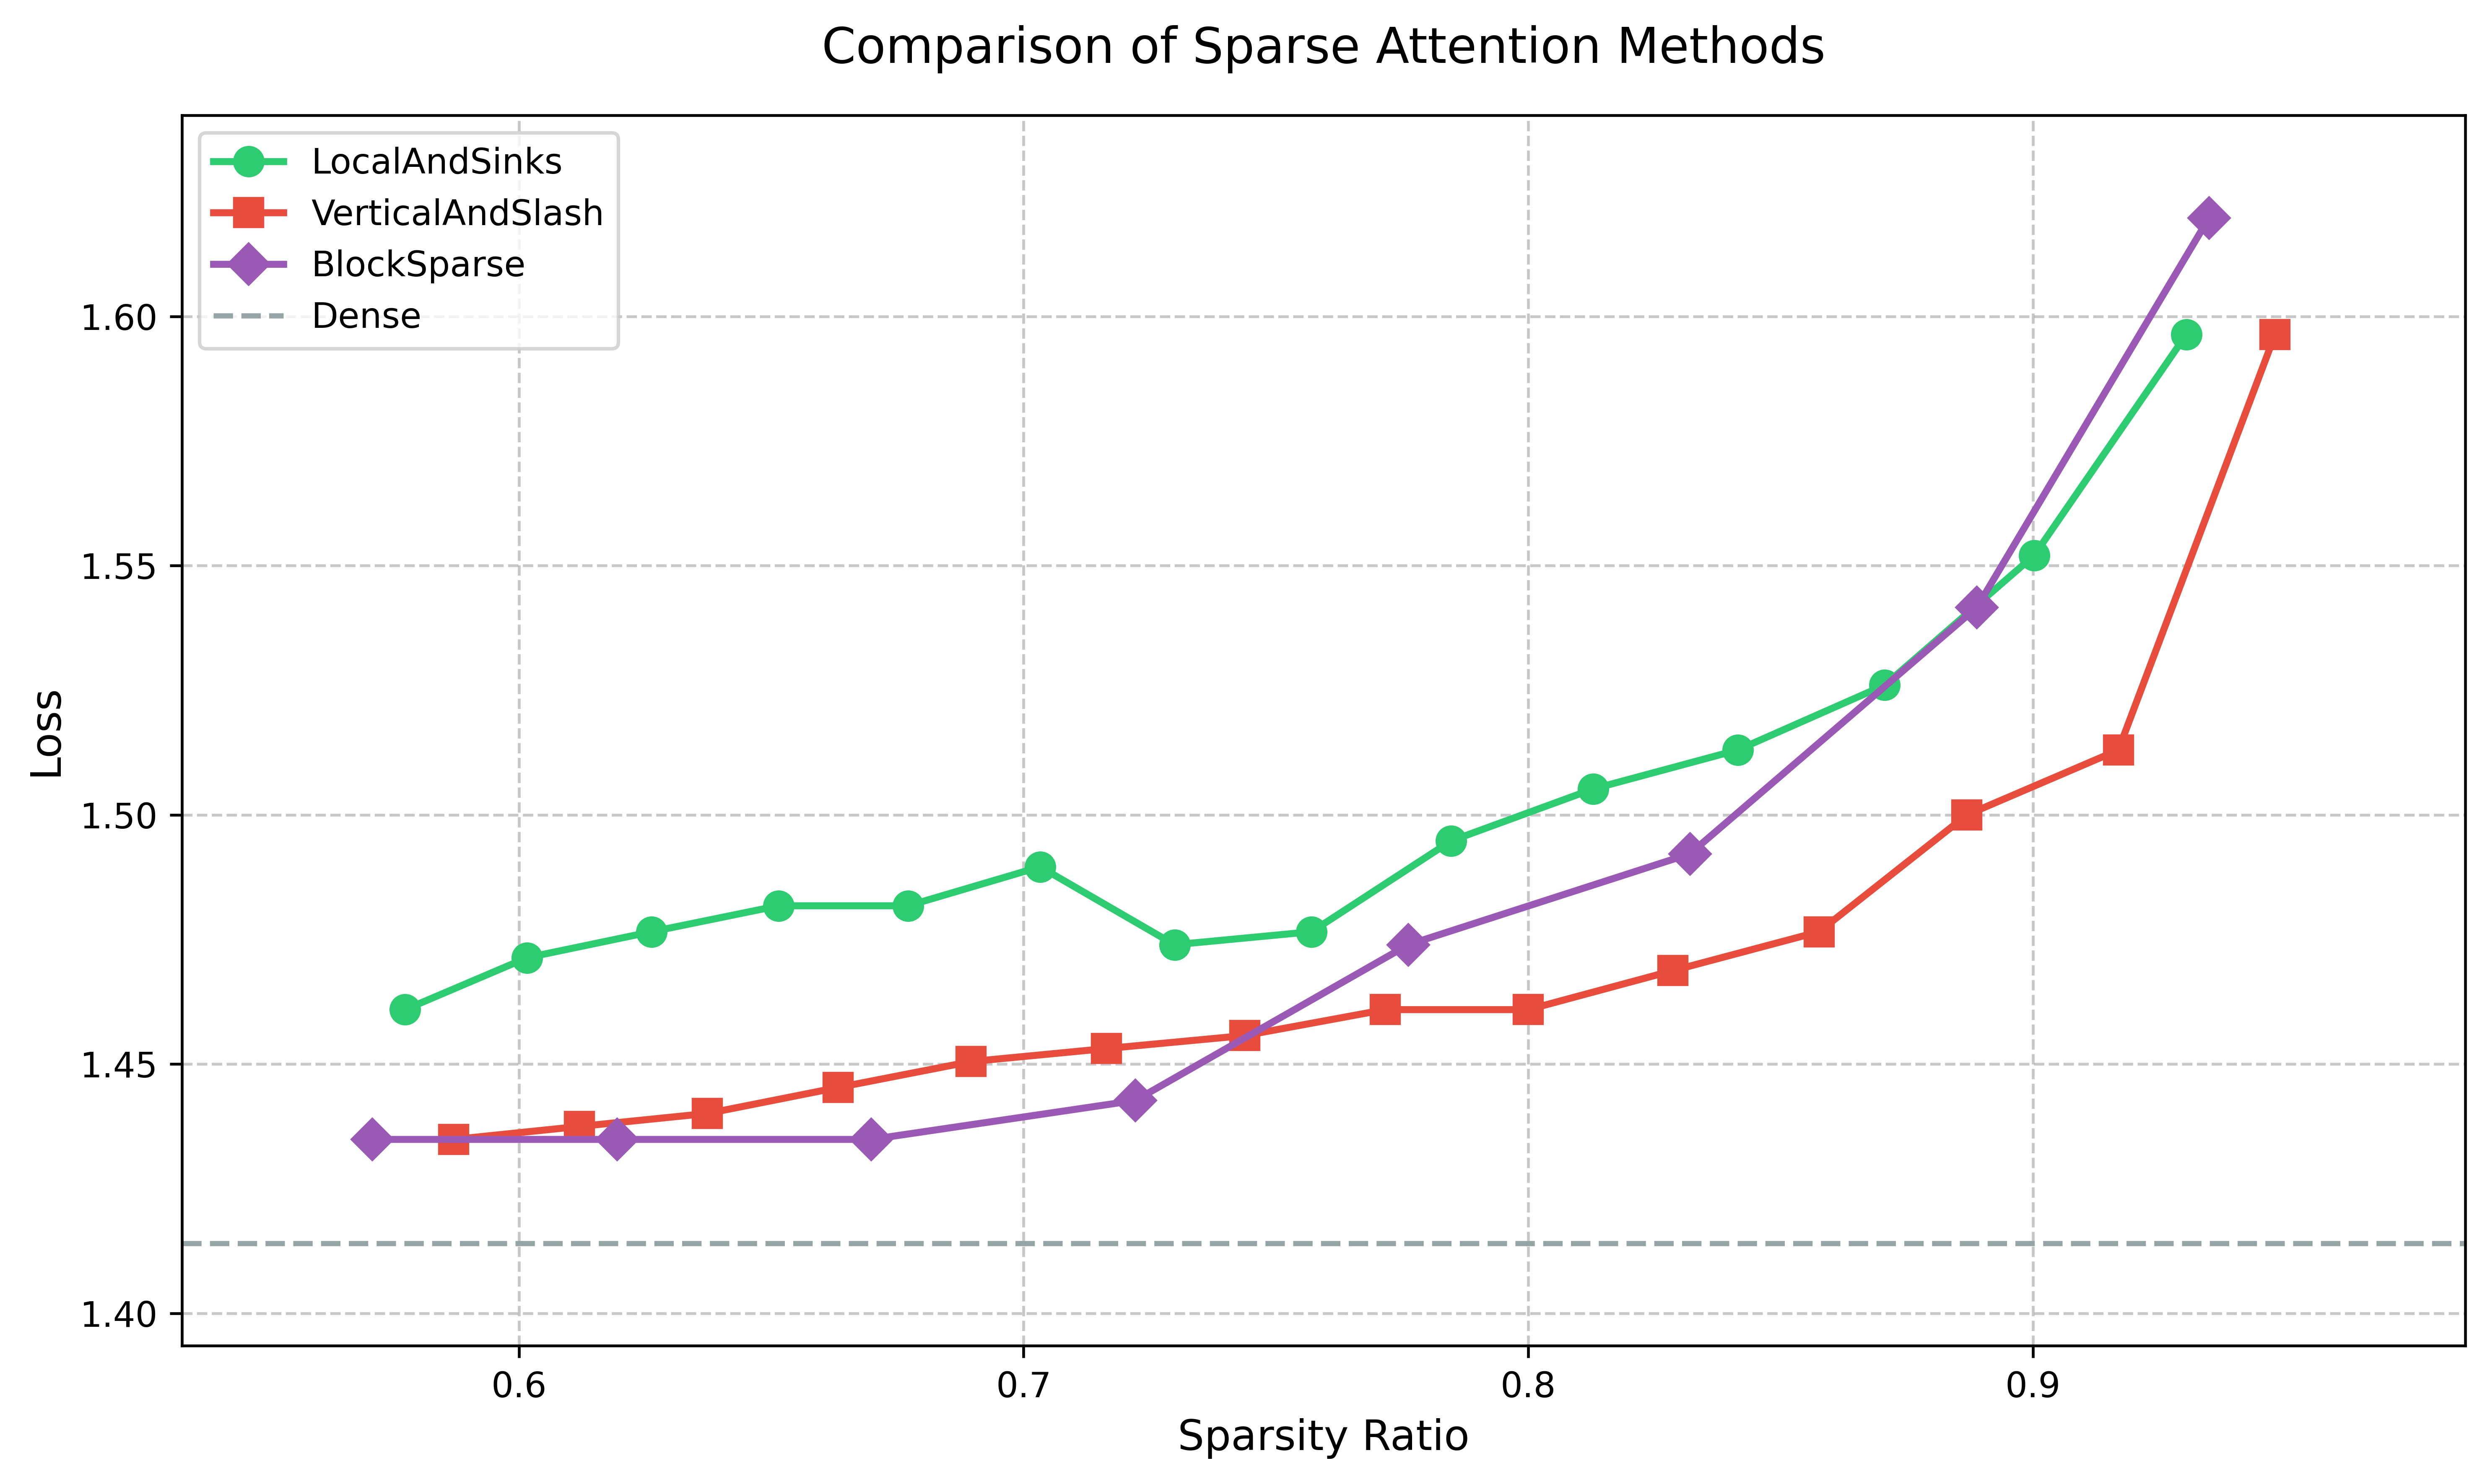

In [7]:
plot_sparse_attention_results(global_results)

Dynamic patterns [VerticalAndSlash and BlockSparse] outperform Static patterns [LocalAndSinks] across all sparsity ratios. Contrary to Input-Independent LocalAndSinks, Dynamic patterns can identify important tokens in the input and adapt their pattern accordingly - according to [Jiang et al, 2024](https://arxiv.org/abs/2407.02490) this is crucial for good performance, especially for high sparsity ratios.

# Generation Stage

Now we'll go through a few example attention patterns for generation stage:
- Dense Attention
- Local Window + Attention Sinks
    - [(Xiao et al, 2023)](https://arxiv.org/abs/2309.17453)
    - [(Han et al, 2024)](https://arxiv.org/abs/2308.16137)
- SnapKV Attention
    - [(Li et al, 2024)](https://arxiv.org/abs/2404.14469)
- TOVA Attention
    - [(Oren et al, 2023)](https://arxiv.org/abs/2401.06104)

In [8]:
global_results = global_results[:1] # Keep only results for Dense

# Update the function to focus on generation stage now
def execute_print_save(model, inference_handler, model_inputs):
    update_attention(model, inference_handler)
    loss = model_forward(model, model_inputs, inference_handler)
    execution_info = inference_handler.info()

    processed_info = {
        'name': execution_info['generation']['name'],
        'sparsity': execution_info['generation']['sparsity'],
        'loss': loss
    }

    print(processed_info)
    global_results.append(processed_info)
    return execution_info

## LocalAndSinksAttention

{'name': 'LocalAndSinksAttention', 'sparsity': 0.9348523666461309, 'loss': 2.4375}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.8735369443893433, 'loss': 2.3880208333333335}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.8122215270996094, 'loss': 2.3255208333333335}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.7509061048428217, 'loss': 2.3098958333333335}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.6895906825860342, 'loss': 2.2552083333333335}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.6282752652963003, 'loss': 2.0546875}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.5669598380724589, 'loss': 2.0026041666666665}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.505644420782725, 'loss': 1.8854166666666667}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.44432900349299115, 'loss': 1.84375}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.38301360607147217, 'loss': 1.7682291666666667}
{'name': 'LocalAndSinksAttention', 'sparsity': 0.3216981689135234, 'loss': 1.7031

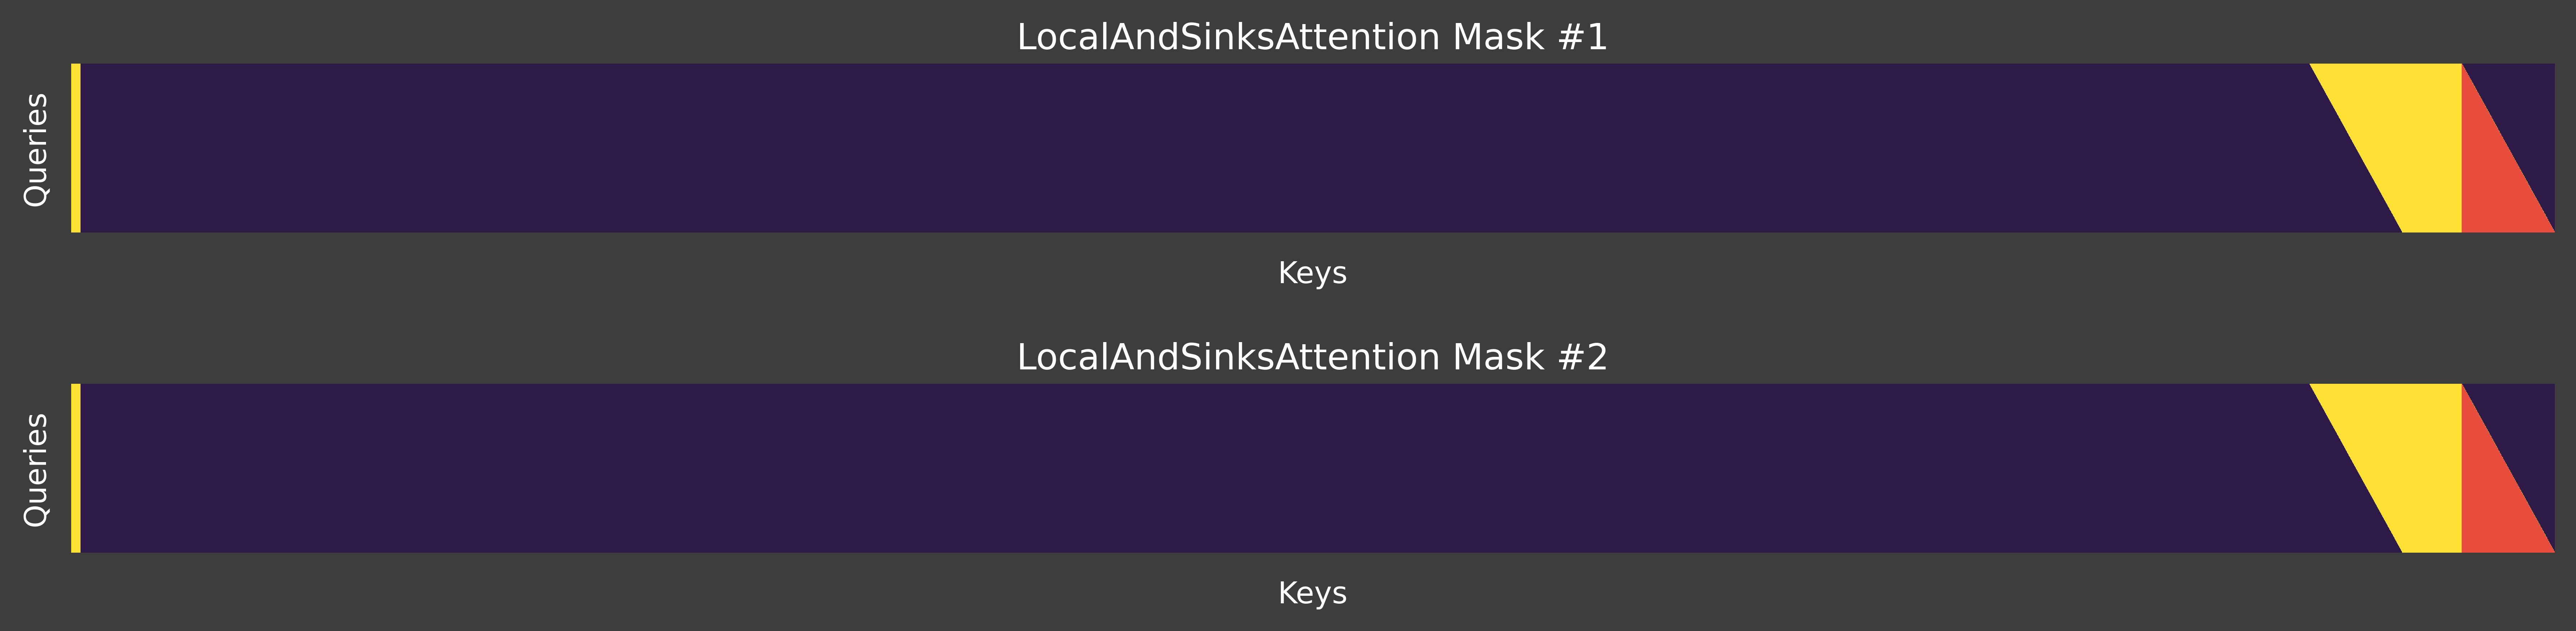

In [9]:
class LocalAndSinksAttention(Attention):
    def __init__(self, window_size, attention_sinks):
        super().__init__()
        self.name = 'LocalAndSinksAttention'
        self.params = {
            "window_size": window_size,
            "attention_sinks": attention_sinks
        }
    
    def create_mask(self, seq_len, device):
        """Creates sparse attention mask with local windows and global sinks."""
        assert self.window_size <= seq_len, "Window size must be less or equal to sequence length"
        assert self.attention_sinks <= seq_len, "Number of attention sinks must be less or equal to sequence length"
        
        # Create base local attention window
        mask = self.get_local_mask(seq_len, self.window_size, device)

        # Allow attention to sink tokens
        mask[..., :, :self.attention_sinks] = 0
        mask = mask | self.get_causal_mask(seq_len, device)

        return mask

    def generation_forward(self, prefilling_queries, prefilling_keys, prefilling_values,
                         generation_queries, generation_keys, generation_values, *args, **kwargs):
        assert self.attention_sinks <= prefilling_queries.size(-2)
    
        total_keys = torch.cat([
            prefilling_keys,
            generation_keys,
        ], dim=-2)

        total_values = torch.cat([
            prefilling_values,
            generation_values,
        ], dim=-2)

        attention_mask = self.create_mask(total_keys.size(-2), generation_queries.device)
        attention_mask = attention_mask[..., -generation_queries.size(-2):, :]

        self.sparsity_ratios.append(self.calculate_sparsity_ratio(attention_mask))
        self.maybe_save_mask(attention_mask)

        return self.attention(generation_queries, total_keys, total_values, attention_mask)


for window_size in range(256, 3844, 256):
    inference_handler = InferenceHandler(
        prefill_attention=DenseAttention(),
        generation_attention=LocalAndSinksAttention(
            window_size=window_size,
            attention_sinks=16,
        ),
    )

    execution_info = execute_print_save(model, inference_handler, model_inputs)

    if window_size == 256:
        plot_generation_masks(
            mask1=execution_info['generation']['masks'][0],
            mask2=execution_info['generation']['masks'][1],
            title=execution_info['generation']['name'],
            mult=0.02,
        )

For the generation stage, we mark allowed interactions between Generation Queries and Keys **Red**, allowed interactions between Generation Queries and Prefilling Keys **Yellow**, and filtered interactions **Blue**.

## SnapKVAttention

{'name': 'SnapKVAttention', 'sparsity': 0.9121333087484041, 'loss': 2.4375}
{'name': 'SnapKVAttention', 'sparsity': 0.8508178939421972, 'loss': 2.2890625}
{'name': 'SnapKVAttention', 'sparsity': 0.7895024667183558, 'loss': 2.1640625}
{'name': 'SnapKVAttention', 'sparsity': 0.7281870444615682, 'loss': 2.0104166666666665}
{'name': 'SnapKVAttention', 'sparsity': 0.6668716371059418, 'loss': 1.8828125}
{'name': 'SnapKVAttention', 'sparsity': 0.6055562098821005, 'loss': 1.7916666666666667}
{'name': 'SnapKVAttention', 'sparsity': 0.544240782658259, 'loss': 1.7135416666666667}
{'name': 'SnapKVAttention', 'sparsity': 0.4829253554344177, 'loss': 1.6276041666666667}
{'name': 'SnapKVAttention', 'sparsity': 0.42160993814468384, 'loss': 1.5703125}
{'name': 'SnapKVAttention', 'sparsity': 0.36029452085494995, 'loss': 1.53125}
{'name': 'SnapKVAttention', 'sparsity': 0.29897910356521606, 'loss': 1.4973958333333333}
{'name': 'SnapKVAttention', 'sparsity': 0.23766366640726724, 'loss': 1.4635416666666667}


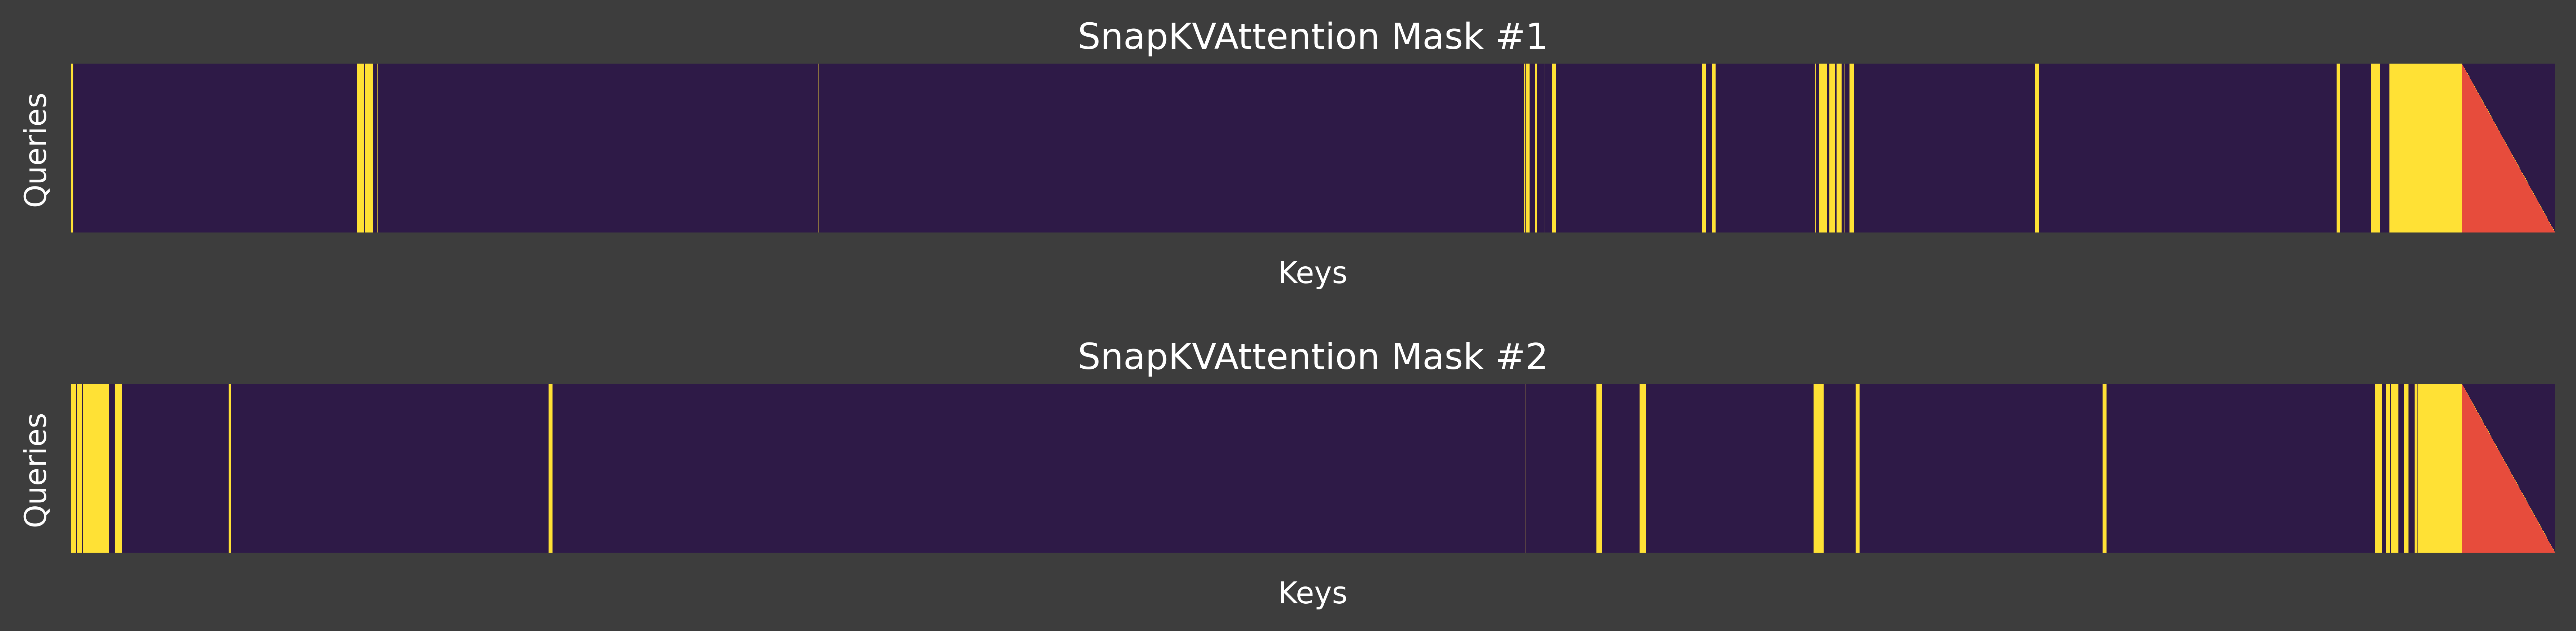

In [10]:
class SnapKVAttention(Attention):
    """Implements SnapKV's attention pattern for efficient text generation.
    
    This attention mechanism compresses the Pre-Filling KV Cache, therefore reducing
    memory usage during generation, by:
    1. Approximating attention scores using a suffix window of queries
    2. Using attention score pooling to identify important token clusters
    3. Keeping only the most relevant tokens plus a recent window
    
    Args:
        token_capacity (int): Maximum number of tokens to keep in compressed history
        approximation_window (int): Number of suffix tokens used to approximate attention scores
        kernel_size (int): Size of the pooling kernel for score aggregation
        
    Reference:
        - (Li et al, 2024) https://arxiv.org/abs/2404.14469
    """
    def __init__(self, token_capacity, approximation_window=64, kernel_size=7):
        super().__init__()
        self.name = 'SnapKVAttention'
        self.params = {
            "token_capacity": token_capacity,
            "approximation_window": approximation_window,
            "kernel_size": kernel_size,
        }

    def create_mask_for_prefill(self, queries, keys, seq_len, device):
        """Create mask for generation with compressed KV cache.
        
        It uses prefilling queries and keys to estimate which tokens will be important
        during generation and keeps only the most important tokens plus a recent window.

        The output mask only concerns the prefilling tokens and has to be extended to
        account for the tokens from the generation phase.
        """
        assert self.token_capacity >= self.approximation_window

        # Approximate attention scores
        approx_queries = queries[..., -self.approximation_window:, :]
        attention_scores = torch.matmul(approx_queries, keys.transpose(-2, -1)) / math.sqrt(queries.size(-1))
        attention_scores[..., -self.approximation_window:] += self.get_causal_mask(self.approximation_window, device) * torch.finfo(queries.dtype).min
        attention_scores = torch.nn.functional.softmax(attention_scores, dim=-1, dtype=torch.float32).to(queries.dtype)
        
        # Sum over queries to get per-key importance and apply average pooling
        key_importance = attention_scores.sum(dim=-2)
        key_importance = F.avg_pool1d(
            key_importance,
            kernel_size=self.kernel_size,
            padding=self.kernel_size // 2,
            stride=1
        )
        
        # Always keep the window tokens
        key_importance[..., -self.approximation_window:] = torch.inf

        # Keep only the top_k tokens
        mask = torch.ones((queries.size(0), queries.size(1), seq_len), dtype=torch.bool, device=device)
        top_indices = key_importance.topk(self.token_capacity, dim=-1).indices
        mask.scatter_(-1, top_indices, False)
        
        # Expand mask to proper attention shape
        mask = mask.unsqueeze(-2)
        
        return mask

    def generation_forward(self, prefilling_queries, prefilling_keys, prefilling_values,
                         generation_queries, generation_keys, generation_values, *args, **kwargs):
        # Concatenate prefilling and generation KV states
        keys = torch.cat([prefilling_keys, generation_keys], dim=-2)
        values = torch.cat([prefilling_values, generation_values], dim=-2)
        
        # Create mask for prefilling tokens
        prefill_mask = self.create_mask_for_prefill(prefilling_queries, prefilling_keys, prefilling_keys.size(-2), generation_queries.device)
        
        # Create dense causal mask for generation tokens
        attention_mask = self.get_generation_mask(
            gen_len=generation_queries.size(-2),
            prefill_len=prefilling_keys.size(-2),
            device=generation_queries.device
        ).repeat(generation_queries.size(0), generation_queries.size(1), 1, 1)

        # Combine masks
        attention_mask[..., :prefilling_keys.size(-2)] |= prefill_mask

        self.sparsity_ratios.append(self.calculate_sparsity_ratio(attention_mask))
        self.maybe_save_mask(attention_mask)
        
        return self.attention(generation_queries, keys, values, attention_mask)


for token_capacity in range(256, 3844, 256):
    inference_handler = InferenceHandler(
        prefill_attention=DenseAttention(),
        generation_attention=SnapKVAttention(token_capacity=token_capacity),
    )

    execution_info = execute_print_save(model, inference_handler, model_inputs)

    if token_capacity == 256:
        plot_generation_masks(
            mask1=execution_info['generation']['masks'][0],
            mask2=execution_info['generation']['masks'][1],
            title=execution_info['generation']['name'],
            mult=0.02,
        )

## TOVAAttention

{'name': 'TOVAAttention', 'sparsity': 0.9384450651705265, 'loss': 2.5052083333333335}
{'name': 'TOVAAttention', 'sparsity': 0.8771296491225561, 'loss': 2.4010416666666665}
{'name': 'TOVAAttention', 'sparsity': 0.8158142218987147, 'loss': 2.2864583333333335}
{'name': 'TOVAAttention', 'sparsity': 0.7544988046089808, 'loss': 2.1510416666666665}
{'name': 'TOVAAttention', 'sparsity': 0.6931833823521932, 'loss': 2.0130208333333335}
{'name': 'TOVAAttention', 'sparsity': 0.6318679650624593, 'loss': 1.8671875}
{'name': 'TOVAAttention', 'sparsity': 0.5705525378386179, 'loss': 1.7630208333333333}
{'name': 'TOVAAttention', 'sparsity': 0.509237120548884, 'loss': 1.6796875}
{'name': 'TOVAAttention', 'sparsity': 0.44792171319325763, 'loss': 1.5989583333333333}
{'name': 'TOVAAttention', 'sparsity': 0.38660629590352374, 'loss': 1.5729166666666667}
{'name': 'TOVAAttention', 'sparsity': 0.32529085874557495, 'loss': 1.5}
{'name': 'TOVAAttention', 'sparsity': 0.26397544145584106, 'loss': 1.4791666666666667

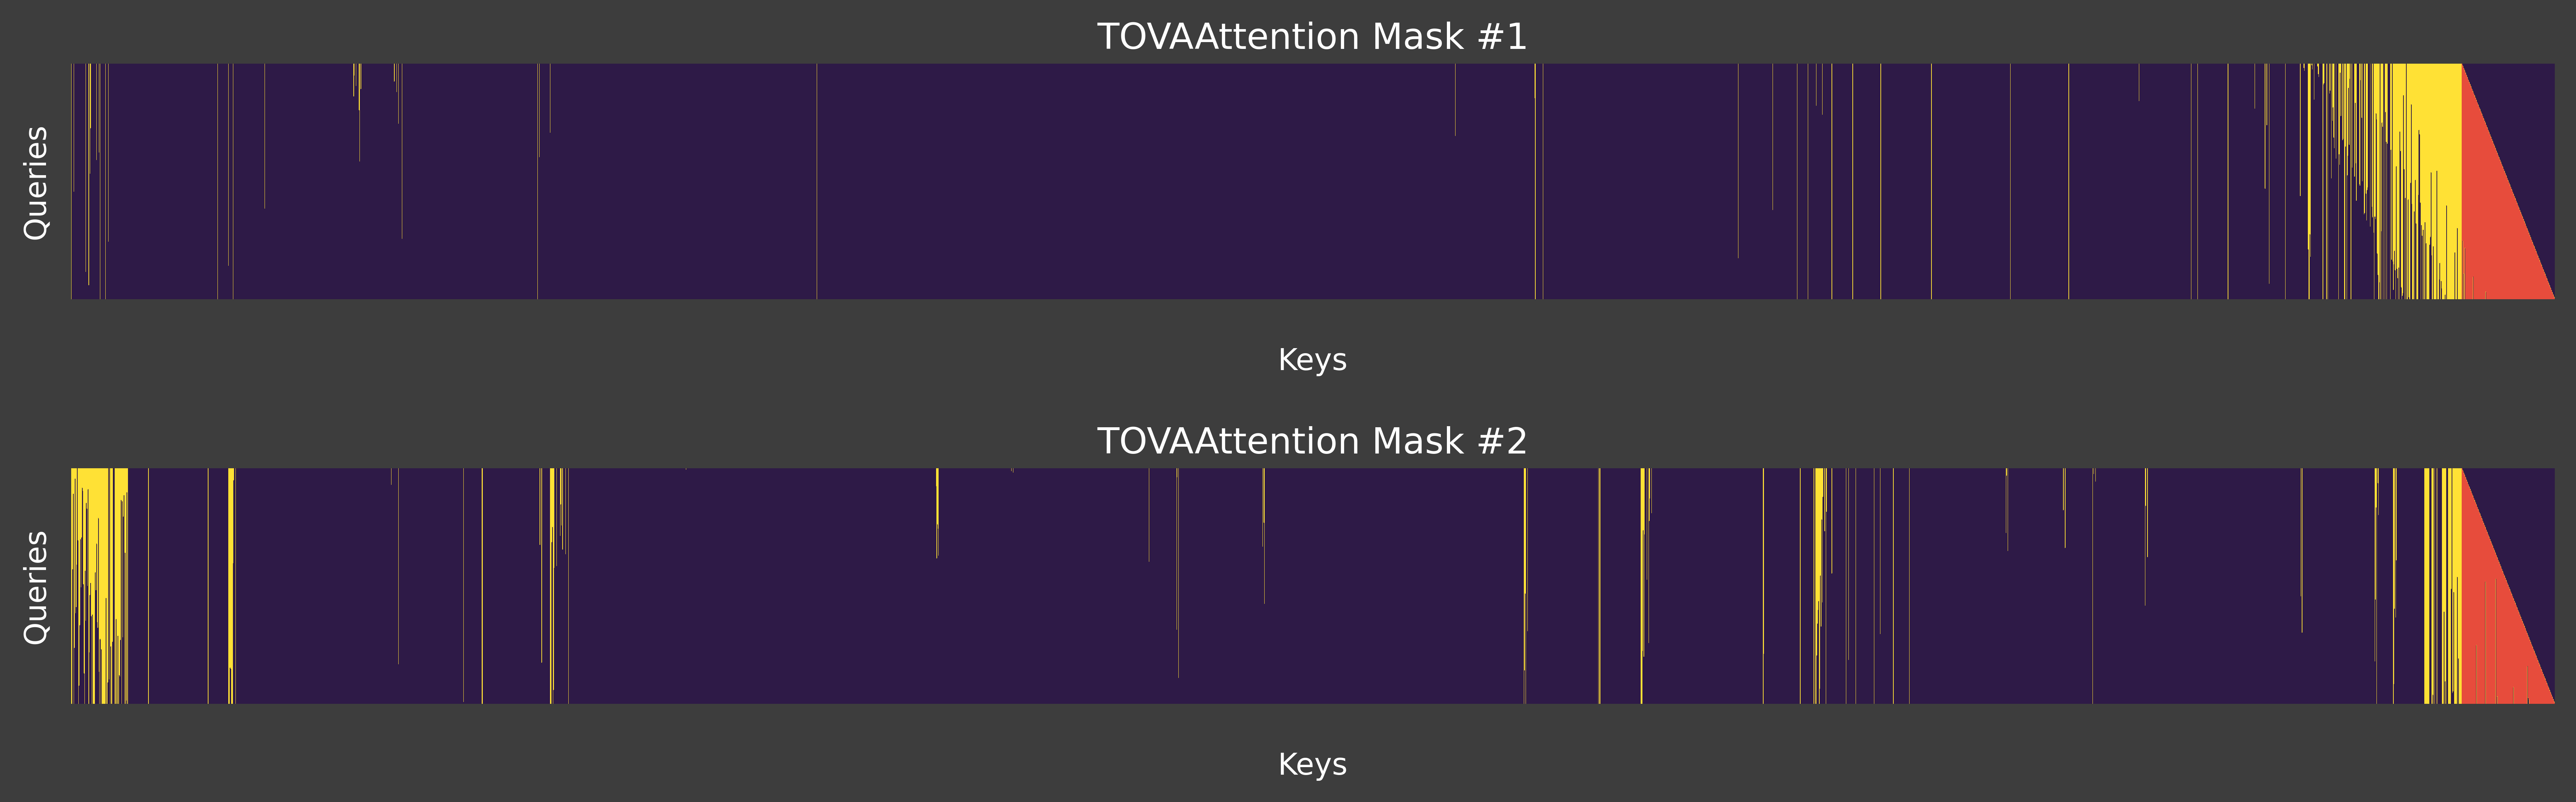

In [11]:
class TOVAAttention(Attention):
    """Implements Token Omission Via Attention (TOVA) for efficient text generation.
    
    This attention mechanism dynamically prunes the KV cache during generation by:
    1. Using the last prefilling token to identify initially important tokens
    2. During generation, maintaining a fixed-size cache by removing the least attended token
       after processing each new token
    
    Args:
        token_capacity (int): Maximum number of tokens to keep in the pruned KV cache
        
    Reference:
        - (Oren et al, 2023) https://arxiv.org/abs/2401.06104
    """
    def __init__(self, token_capacity):
        super().__init__()
        self.name = 'TOVAAttention'
        self.params = {
            "token_capacity": token_capacity
        }

    def create_mask_for_prefill(self, queries, keys, seq_len, device):
        """Create initial mask based on attention scores from the last prefilling token."""
        if self.token_capacity >= seq_len:
            return torch.zeros((queries.size(0), queries.size(1), 1, seq_len), dtype=torch.bool, device=device)
        
        # Get attention scores for the last prefilling token
        last_query = queries[..., -1:, :]
        attention_scores = torch.matmul(last_query, keys.transpose(-2, -1)) / math.sqrt(queries.size(-1))
        attention_scores = torch.nn.functional.softmax(attention_scores, dim=-1, dtype=torch.float32).to(queries.dtype)
        
        # Average attention scores across heads
        mean_attention_scores = attention_scores.mean(dim=1)
        
        # Create mask keeping only top-k tokens
        mask = torch.ones((queries.size(0), queries.size(1), seq_len), dtype=torch.bool, device=device)
        top_indices = mean_attention_scores.topk(self.token_capacity, dim=-1).indices
        mask.scatter_(-1, top_indices.expand(-1, queries.size(1), -1), False)
        
        # Expand mask to proper attention shape
        mask = mask.unsqueeze(-2)

        return mask

    def generation_forward(self, prefilling_queries, prefilling_keys, prefilling_values,
                         generation_queries, generation_keys, generation_values, *args, **kwargs):
        # Get initial mask for prefilling tokens
        current_mask = self.create_mask_for_prefill(
            prefilling_queries, 
            prefilling_keys, 
            prefilling_keys.size(-2), 
            generation_queries.device
        )
        
        # Initialize lists to store outputs and updated keys/values
        outputs = []
        current_keys = prefilling_keys
        current_values = prefilling_values

        # Intialise final mask we'll output
        attention_mask = torch.ones((
            generation_queries.size(0),
            generation_queries.size(1),
            generation_queries.size(2),
            prefilling_keys.size(-2) + generation_keys.size(-2),
        ), dtype=torch.bool, device=generation_queries.device)
        
        # Process generation tokens one by one
        for idx in range(generation_queries.size(-2)):
            # Get current generation token
            current_query = generation_queries[..., idx:idx+1, :]
            current_gen_key = generation_keys[..., idx:idx+1, :]
            current_gen_value = generation_values[..., idx:idx+1, :]
            
            # Extend keys and values
            current_keys = torch.cat([current_keys, current_gen_key], dim=-2)
            current_values = torch.cat([current_values, current_gen_value], dim=-2)
            
            # Extend mask for the new token (always attended)
            current_mask = torch.cat([
                current_mask,
                torch.zeros((current_query.size(0), current_query.size(1), 1, 1), dtype=torch.bool, device=current_query.device)
            ], dim=-1)

            attention_mask[..., idx:idx+1, :current_keys.size(-2)] = current_mask
            
            # Compute attention with scores
            output, attention_scores = self.attention(
                current_query, 
                current_keys,
                current_values,
                current_mask,
                return_attention_scores=True
            )
            outputs.append(output)

            # If we exceed capacity, mask the token with lowest attention score
            if current_keys.size(-2) > self.token_capacity:
                # Set scores to inf where tokens were already masked
                attention_scores = attention_scores.masked_fill(current_mask, float('inf'))

                # Average attention scores across heads
                mean_scores = attention_scores.mean(dim=1, keepdim=True)

                # Find token with lowest attention score
                min_indices = mean_scores.argmin(dim=-1, keepdim=True)
                min_indices = min_indices.expand(-1, current_query.size(1), -1, -1)

                # Update mask to exclude the lowest scoring token
                current_mask.scatter_(-1, min_indices, True)
        
        # Concatenate all outputs
        final_output = torch.cat(outputs, dim=-2)
        
        self.sparsity_ratios.append(self.calculate_sparsity_ratio(attention_mask))
        self.maybe_save_mask(attention_mask)

        return final_output


for token_capacity in range(256, 3844, 256):
    inference_handler = InferenceHandler(
        prefill_attention=DenseAttention(),
        generation_attention=TOVAAttention(token_capacity=token_capacity),
    )

    execution_info = execute_print_save(model, inference_handler, model_inputs)

    if token_capacity == 256:
        plot_generation_masks(
            mask1=execution_info['generation']['masks'][0],
            mask2=execution_info['generation']['masks'][1],
            title=execution_info['generation']['name'],
            mult=0.025,
        )

In the above visualisation of the attention mask, some vertical lines are cut off. This is because TOVA maintains a fixed-size cache of tokens, and as the generation progresses, it removes the least attended tokens. Contrary, SnapKV identifies an important set of tokens **before generation starts** and keeps them in the cache for the entire generation.

## [Discussion] - Which method is the best?

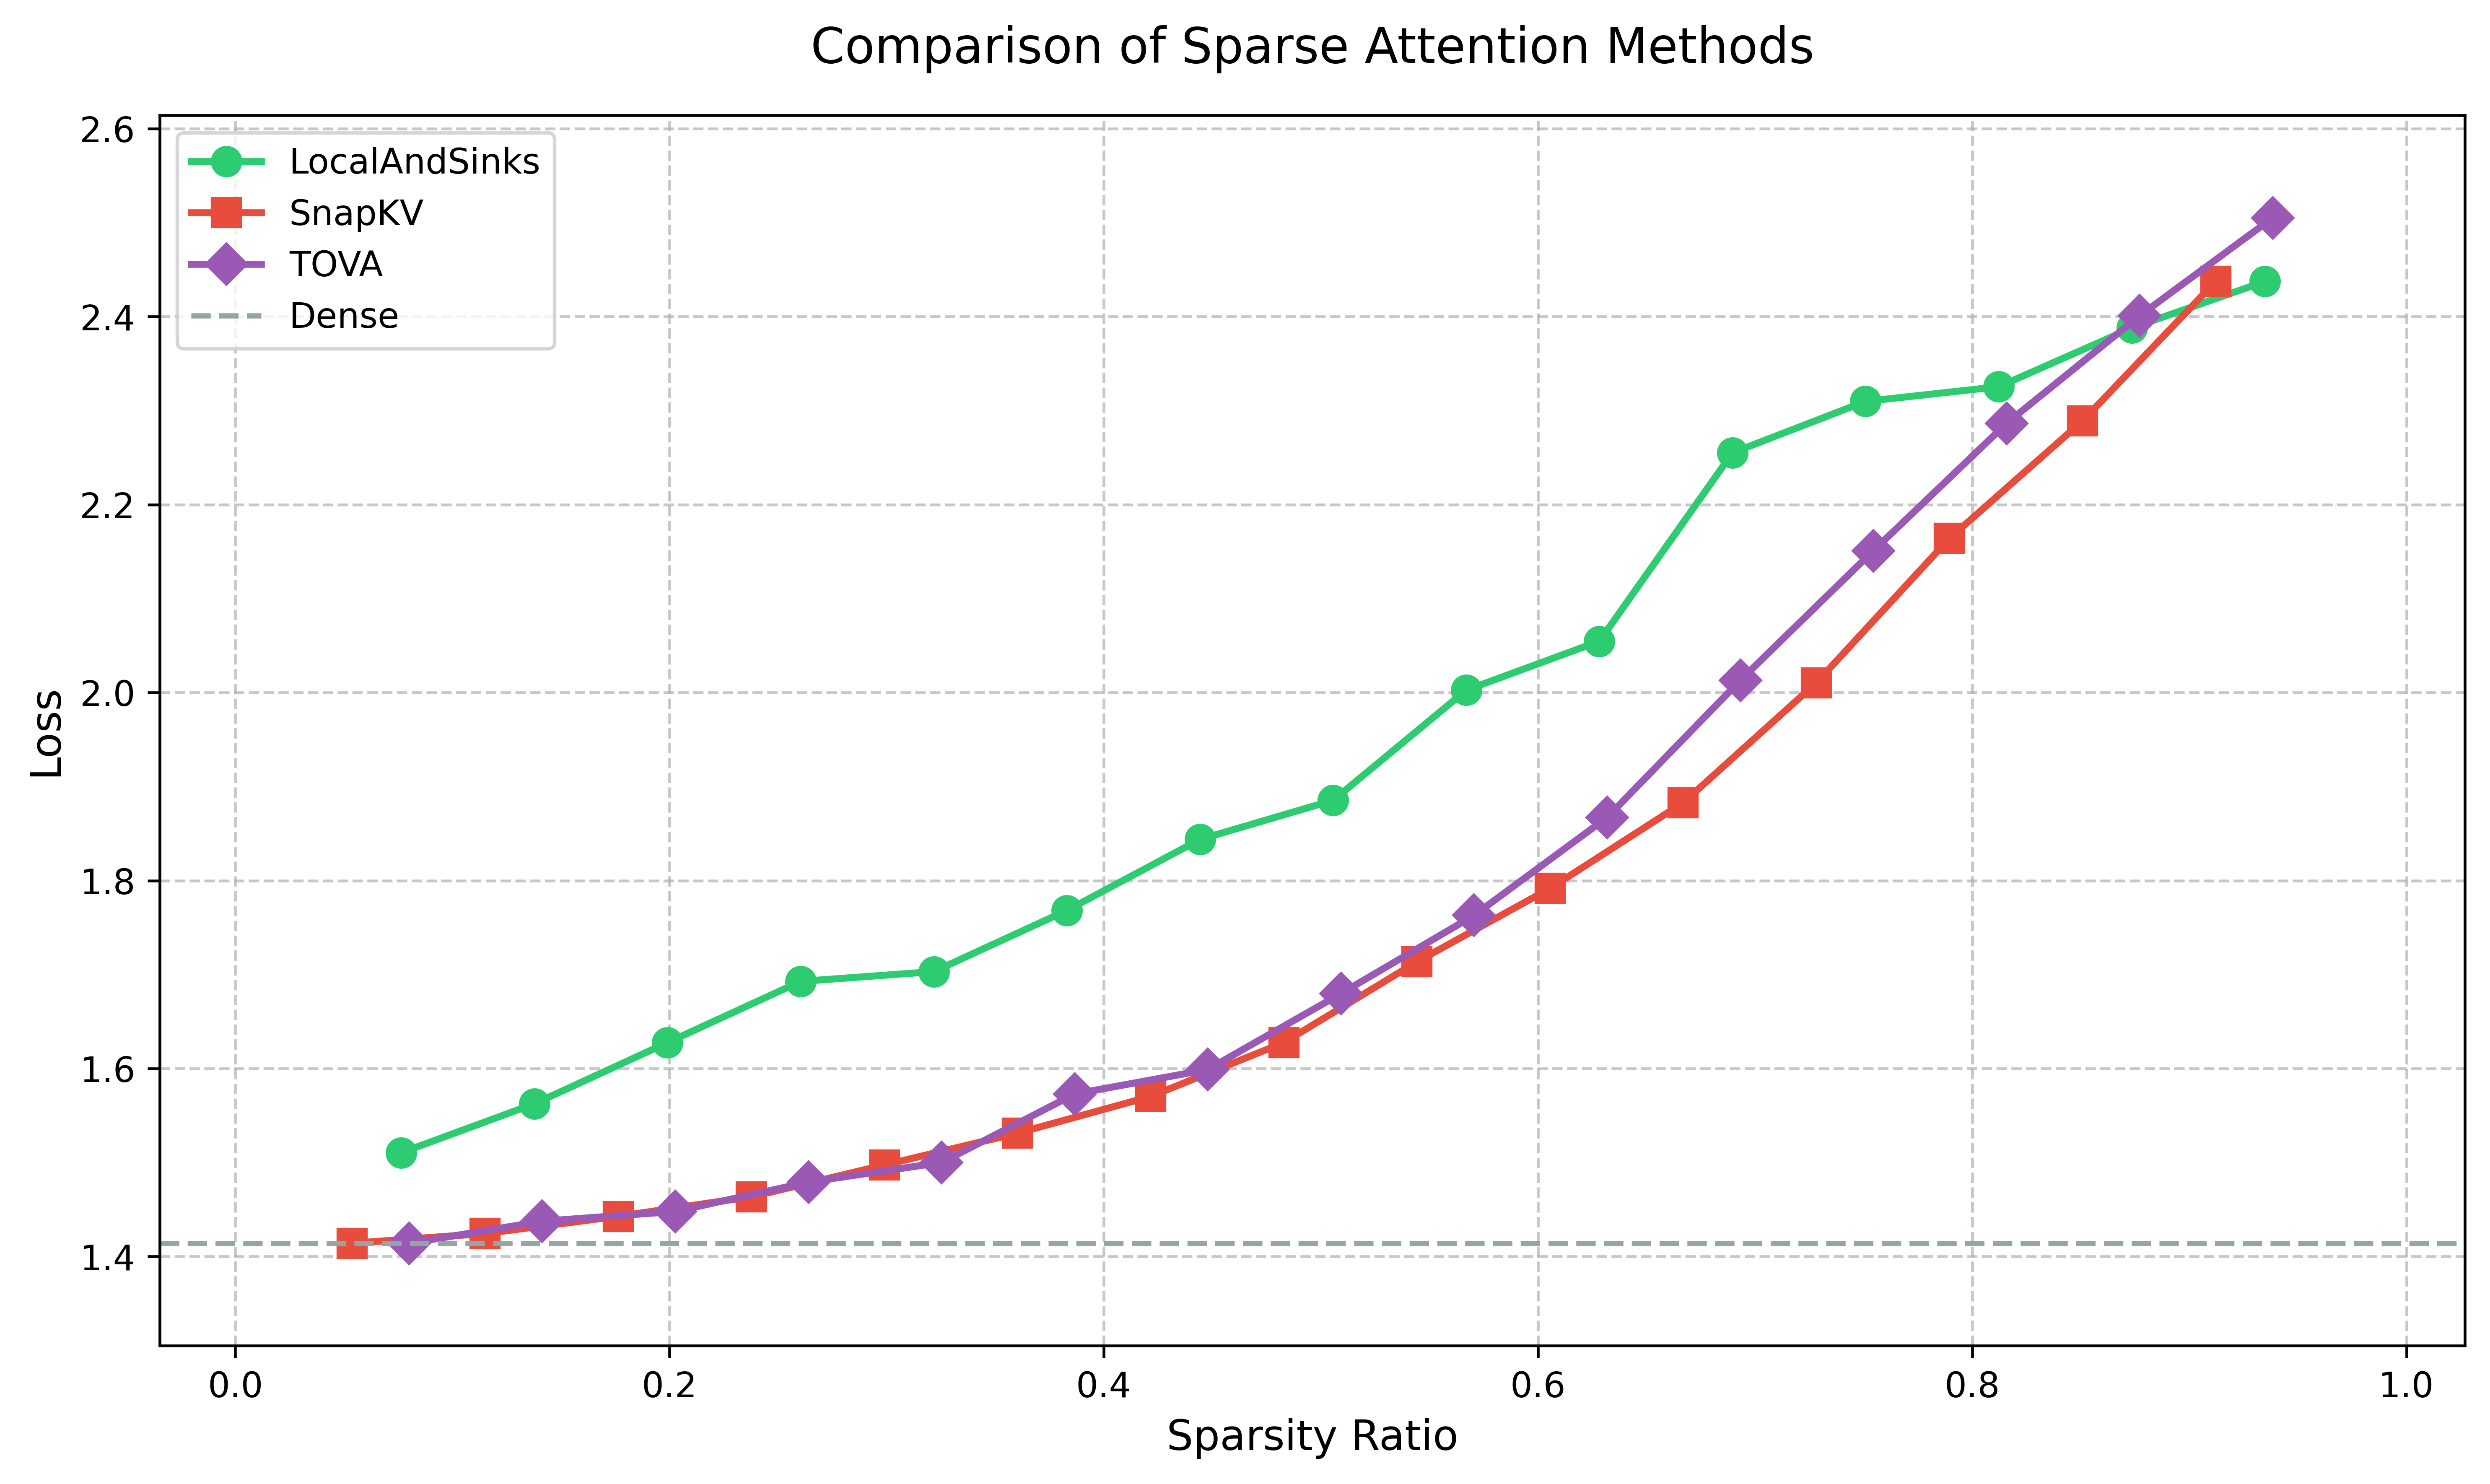

In [12]:
from nano_sparse_attn.utils.plotting import plot_sparse_attention_results
plot_sparse_attention_results(global_results)

Dynamic Approaches (SnapKV, TOVA) outperform Static LocalAndSinks across all sparsity ratios. This result is expected, especially for the task of summarization, where the output depends on the entire input. For small window sizes, LocalAndSinks simply cannot access the beginning of the input, which is crucial for summarization. On the other hand, Dynamic Approaches allow the model to retrieve tokens from any part of the input.